In [1]:
# Cell 1: Environment Setup and Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json
import requests
import base64
import pickle
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        gpu_count = torch.cuda.device_count()
        current_device = torch.cuda.current_device()
        
        print(f"CUDA Available: {torch.cuda.is_available()}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"PyTorch Version: {torch.__version__}")
        print(f"GPU Count: {gpu_count}")
        print(f"Current Device: {current_device}")
        print(f"Device Name: {torch.cuda.get_device_name(current_device)}")

        # Memory information
        props = torch.cuda.get_device_properties(current_device)
        print(f"Total Memory: {props.total_memory / 1e9:.1f} GB")
        print(f"Major: {props.major}, Minor: {props.minor}")
        print(f"Multi Processor Count: {props.multi_processor_count}")

        # Set memory allocation strategy
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True
        print("CUDA optimizations enabled")
    else:
        device = torch.device('cpu')
        print("CUDA not available, using CPU")
    
    return device

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seeds set to {seed}")

# Check CUDA availability
device = setup_device()
set_seeds(42)
print("Libraries imported successfully!")

CUDA Available: True
CUDA Version: 12.4
PyTorch Version: 2.5.1
GPU Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 2060
Total Memory: 6.4 GB
Major: 7, Minor: 5
Multi Processor Count: 30
CUDA optimizations enabled
Random seeds set to 42
Libraries imported successfully!


In [2]:
# Cell 2: Dataset Configuration and Paths
# Dataset path
DATASET_PATH = r"/home/azizfrahman/project/avengers-facial-recognition/data/images"

# Configuration
CONFIG = {
    'img_size': (112, 112),  # As per research requirements
    'train_test_split': 0.8,
    'batch_size': 32,
    'angles': ['frontal', '30_degree', '45_degree'],
    'augmentation': True,
    'grayscale': False,
    'face_api_url': 'http://localhost:5000',
    'models_path': './models',
    'cache_enabled': True,
    'max_retries': 3,
    'timeout': 30,
    'jpeg_quality': 95
}

# Create directories for processed data
PROCESSED_DATA_PATH = os.path.join(DATASET_PATH, 'processed')
EMBEDDINGS_CACHE_PATH = os.path.join(PROCESSED_DATA_PATH, 'embeddings_cache.pkl')
RESULTS_PATH = os.path.join(PROCESSED_DATA_PATH, 'results')
MODELS_PATH = CONFIG['models_path']

# Create all necessary directories
directories = [PROCESSED_DATA_PATH, RESULTS_PATH, MODELS_PATH]
for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Directory created/verified: {directory}")

print(f"Dataset Path: {DATASET_PATH}")
print(f"Processed Data Path: {PROCESSED_DATA_PATH}")
print(f"Cache Path: {EMBEDDINGS_CACHE_PATH}")
print(f"Results Path: {RESULTS_PATH}")
print(f"Models Path: {MODELS_PATH}")
print(f"Configuration: {json.dumps(CONFIG, indent=2)}")

Directory created/verified: /home/azizfrahman/project/avengers-facial-recognition/data/images/processed
Directory created/verified: /home/azizfrahman/project/avengers-facial-recognition/data/images/processed/results
Directory created/verified: ./models
Dataset Path: /home/azizfrahman/project/avengers-facial-recognition/data/images
Processed Data Path: /home/azizfrahman/project/avengers-facial-recognition/data/images/processed
Cache Path: /home/azizfrahman/project/avengers-facial-recognition/data/images/processed/embeddings_cache.pkl
Results Path: /home/azizfrahman/project/avengers-facial-recognition/data/images/processed/results
Models Path: ./models
Configuration: {
  "img_size": [
    112,
    112
  ],
  "train_test_split": 0.8,
  "batch_size": 32,
  "angles": [
    "frontal",
    "30_degree",
    "45_degree"
  ],
  "augmentation": true,
  "grayscale": false,
  "face_api_url": "http://localhost:5000",
  "models_path": "./models",
  "cache_enabled": true,
  "max_retries": 3,
  "timeou

In [3]:
# Cell 3: Setup Face-api.js Server
# Create a Node.js server script for face-api.js

node_server_code = '''
const express = require('express');
const faceapi = require('face-api.js');
const canvas = require('canvas');
const fs = require('fs');
const path = require('path');

// Monkey patch for face-api.js to work with canvas
const { Canvas, Image, ImageData } = canvas;
faceapi.env.monkeyPatch({ Canvas, Image, ImageData });

const app = express();

// Enhanced middleware
app.use(express.json({ limit: '50mb' }));
app.use(express.urlencoded({ extended: true, limit: '50mb' }));

// CORS middleware for cross-origin requests
app.use((req, res, next) => {
    res.header('Access-Control-Allow-Origin', '*');
    res.header('Access-Control-Allow-Methods', 'GET, POST, PUT, DELETE, OPTIONS');
    res.header('Access-Control-Allow-Headers', 'Origin, X-Requested-With, Content-Type, Accept, Authorization');

    if (req.method === 'OPTIONS') {
        return res.sendStatus(200);
    } else {
        next();
    }
});

// Logging middleware
app.use((req, res, next) => {
    const timestamp = new Date().toISOString();
    console.log(`${timestamp} - ${req.method} ${req.path}`);
    next();
});

// Load models
const MODEL_URL = './models';
let modelsLoaded = false;
let loadingProgress = {};

async function loadModels() {
    try {
        console.log('\\n Loading face-api.js models...');
        const startTime = Date.now();
        
        // Define all required models
        const modelLoaders = [
            { name: 'TinyFaceDetector', loader: () => faceapi.nets.tinyFaceDetector.loadFromDisk(MODEL_URL) },
            { name: 'FaceLandmark68Net', loader: () => faceapi.nets.faceLandmark68Net.loadFromDisk(MODEL_URL) },
            { name: 'FaceRecognitionNet', loader: () => faceapi.nets.faceRecognitionNet.loadFromDisk(MODEL_URL) },
            { name: 'FaceExpressionNet', loader: () => faceapi.nets.faceExpressionNet.loadFromDisk(MODEL_URL) },
            { name: 'AgeGenderNet', loader: () => faceapi.nets.ageGenderNet.loadFromDisk(MODEL_URL) },
            { name: 'SsdMobilenetv1', loader: () => faceapi.nets.ssdMobilenetv1.loadFromDisk(MODEL_URL) }
        ];
        
        // Load models with progress tracking
        for (const model of modelLoaders) {
            try {
                console.log(`  Loading ${model.name}...`);
                await model.loader();
                loadingProgress[model.name] = 'loaded';
                console.log(`${model.name} loaded successfully`);
            } catch (error) {
                console.error(`Failed to load ${model.name}:`, error.message);
                loadingProgress[model.name] = 'failed';
                throw error;
            }
        }
        
        const endTime = Date.now();
        modelsLoaded = true;
        console.log(`\\n All models loaded successfully in ${endTime - startTime}ms`);
        return true;
    } catch (error) {
        console.error(' Error loading models:', error);
        modelsLoaded = false;
        return false;
    }
}

// Enhanced health check endpoint
app.get('/health', (req, res) => {
    const memUsage = process.memoryUsage();
    const health = {
        status: 'ok',
        timestamp: new Date().toISOString(),
        uptime: process.uptime(),
        modelsLoaded: modelsLoaded,
        loadingProgress: loadingProgress,
        memory: {
            rss: Math.round(memUsage.rss / 1024 / 1024) + ' MB',
            heapTotal: Math.round(memUsage.heapTotal / 1024 / 1024) + ' MB',
            heapUsed: Math.round(memUsage.heapUsed / 1024 / 1024) + ' MB'
        },
        nodeVersion: process.version
    };
    
    res.json(health);
});

// Model status endpoint
app.get('/models', (req, res) => {
    res.json({
        modelsLoaded: modelsLoaded,
        loadingProgress: loadingProgress,
        availableModels: Object.keys(loadingProgress)
    });
});

// Enhanced face detection with multiple strategies
app.post('/extract_embedding', async (req, res) => {
    if (!modelsLoaded) {
        return res.status(503).json({ 
            success: false,
            error: 'Models not loaded yet',
            progress: loadingProgress
        });
    }
    
    const startTime = Date.now();
    
    try {
        const { image } = req.body;
        
        if (!image) {
            return res.status(400).json({
                success: false,
                error: 'No image provided in request body'
            });
        }
        
        // Load image from base64
        let img;
        try {
            const buffer = Buffer.from(image, 'base64');
            img = await canvas.loadImage(buffer);
        } catch (error) {
            return res.status(400).json({
                success: false,
                error: 'Invalid image format or corrupted base64 data'
            });
        }
        
        // Multiple detection strategies for better success rate
        const detectionStrategies = [
            {
                name: 'TinyFaceDetector_High',
                options: new faceapi.TinyFaceDetectorOptions({ 
                    inputSize: 416, 
                    scoreThreshold: 0.3 
                })
            },
            {
                name: 'TinyFaceDetector_Medium',
                options: new faceapi.TinyFaceDetectorOptions({ 
                    inputSize: 320, 
                    scoreThreshold: 0.4 
                })
            },
            {
                name: 'TinyFaceDetector_Low',
                options: new faceapi.TinyFaceDetectorOptions({ 
                    inputSize: 224, 
                    scoreThreshold: 0.5 
                })
            },
            {
                name: 'SsdMobilenetv1',
                options: new faceapi.SsdMobilenetv1Options({ 
                    minConfidence: 0.3 
                })
            }
        ];
        
        let detection = null;
        let usedStrategy = null;
        
        // Try each strategy until one succeeds
        for (const strategy of detectionStrategies) {
            try {
                const detectionStartTime = Date.now();
                
                detection = await faceapi.detectSingleFace(img, strategy.options)
                    .withFaceLandmarks()
                    .withFaceDescriptor();
                
                if (detection && detection.descriptor) {
                    usedStrategy = strategy.name;
                    console.log(`Detection successful with ${strategy.name} in ${Date.now() - detectionStartTime}ms`);
                    break;
                }
            } catch (err) {
                console.warn(` Detection failed with ${strategy.name}:`, err.message);
                continue;
            }
        }
        
        const totalTime = Date.now() - startTime;
        
        if (detection && detection.descriptor) {
            // Successful detection
            const response = {
                success: true,
                embedding: Array.from(detection.descriptor),
                inferenceTime: totalTime,
                strategy: usedStrategy,
                boundingBox: {
                    x: Math.round(detection.detection.box.x),
                    y: Math.round(detection.detection.box.y),
                    width: Math.round(detection.detection.box.width),
                    height: Math.round(detection.detection.box.height)
                },
                confidence: detection.detection.score || 0.0,
                landmarks: detection.landmarks ? detection.landmarks.positions.length : 0
            };
            
            console.log(` Embedding extracted successfully (${totalTime}ms)`);
            res.json(response);
        } else {
            // Failed detection
            const response = {
                success: false,
                error: 'No face detected with any strategy',
                inferenceTime: totalTime,
                strategiesTried: detectionStrategies.map(s => s.name)
            };
            console.log(` Face detection failed (${totalTime}ms)`);
            res.json(response);
        }
    } catch (error) {
        const totalTime = Date.now() - startTime;
        console.error(' Extraction error:', error);
        res.status(500).json({ 
            success: false,
            error: error.message,
            inferenceTime: totalTime
        });
    }
});

// Batch processing endpoint with progress tracking
app.post('/batch_extract', async (req, res) => {
    if (!modelsLoaded) {
        return res.status(503).json({ 
            error: 'Models not loaded yet',
            progress: loadingProgress
        });
    }
    
    try {
        const { images } = req.body;
        
        if (!images || !Array.isArray(images)) {
            return res.status(400).json({ 
                error: 'Images array is required' 
            });
        }
        
        console.log(` Starting batch processing of ${images.length} images`);
        const results = [];
        const startTime = Date.now();
        
        for (let i = 0; i < images.length; i++) {
            const imageStartTime = Date.now();
            
            try {
                const img = await canvas.loadImage(Buffer.from(images[i], 'base64'));
                
                const detection = await faceapi.detectSingleFace(img, 
                    new faceapi.TinyFaceDetectorOptions({ inputSize: 416, scoreThreshold: 0.3 }))
                    .withFaceLandmarks()
                    .withFaceDescriptor();
                
                const imageTime = Date.now() - imageStartTime;
                
                if (detection && detection.descriptor) {
                    results.push({
                        index: i,
                        success: true,
                        embedding: Array.from(detection.descriptor),
                        inferenceTime: imageTime,
                        confidence: detection.detection.score || 0.0
                    });
                } else {
                    results.push({
                        index: i,
                        success: false,
                        inferenceTime: imageTime,
                        error: 'No face detected'
                    });
                }
            } catch (error) {
                results.push({
                    index: i,
                    success: false,
                    inferenceTime: Date.now() - imageStartTime,
                    error: error.message
                });
            }
            
            // Progress logging
            if ((i + 1) % 10 === 0) {
                console.log(` Processed ${i + 1}/${images.length} images`);
            }
        }
        
        const totalTime = Date.now() - startTime;
        const successful = results.filter(r => r.success).length;

        console.log(` Batch processing complete: ${successful}/${images.length} successful in ${totalTime}ms`);
        
        res.json({ 
            results,
            summary: {
                total: images.length,
                successful: successful,
                failed: images.length - successful,
                totalTime: totalTime,
                averageTime: Math.round(totalTime / images.length)
            }
        });
    } catch (error) {
        console.error(' Batch processing error:', error);
        res.status(500).json({ error: error.message });
    }
});

// Statistics endpoint
app.get('/stats', (req, res) => {
    const stats = {
        modelsLoaded: modelsLoaded,
        uptime: process.uptime(),
        memory: process.memoryUsage(),
        loadingProgress: loadingProgress
    };
    
    res.json(stats);
});

// Error handling middleware
app.use((error, req, res, next) => {
    console.error(' Unhandled error:', error);
    res.status(500).json({ 
        error: 'Internal server error',
        message: error.message 
    });
});

// 404 handler
app.use('*', (req, res) => {
    res.status(404).json({ 
        error: 'Endpoint not found',
        availableEndpoints: ['/health', '/models', '/extract_embedding', '/batch_extract', '/stats']
    });
});

// Server configuration
const PORT = process.env.PORT || 5000;

// Graceful shutdown handling
process.on('SIGINT', () => {
    console.log('\\n Received SIGINT, shutting down gracefully...');
    process.exit(0);
});

process.on('SIGTERM', () => {
    console.log('\\n Received SIGTERM, shutting down gracefully...');
    process.exit(0);
});

// Start server
console.log(' Starting Face-api.js server...');
console.log(` Port: ${PORT}`);
console.log(` Models path: ${MODEL_URL}`);

loadModels().then((success) => {
    if (success) {
        app.listen(PORT, () => {
            console.log('\\n' + '='.repeat(60));
            console.log(' FACE-API.JS SERVER READY');
            console.log('='.repeat(60));
            console.log(` Server URL: http://localhost:${PORT}`);
            console.log(` Health check: http://localhost:${PORT}/health`);
            console.log(` Models status: http://localhost:${PORT}/models`);
            console.log(` Statistics: http://localhost:${PORT}/stats`);
            console.log('='.repeat(60));
        });
    } else {
        console.error(' Failed to load models. Server not started.');
        console.error(' Make sure all model files are in the ./models directory');
        process.exit(1);
    }
}).catch((error) => {
    console.error(' Fatal error during startup:', error);
    process.exit(1);
});
'''

# Save the server code
with open('faceapi_server.js', 'w') as f:
    f.write(node_server_code)

print("\n Setup Instructions:")
print("  1. Install Node.js (https://nodejs.org)")
print("  2. Run: npm install")
print("  3. Start server: npm start")


 Setup Instructions:
  1. Install Node.js (https://nodejs.org)
  2. Run: npm install
  3. Start server: npm start


In [4]:
# Cell 4: Data Loading and Preprocessing Functions
class DataValidator:
    def validate_image(self,image_path):
        """Validate image file"""
        try:
            if not os.path.exists(image_path):
                return False, "File does not exist"
            
            # Check file size
            file_size = os.path.getsize(image_path)
            if file_size == 0:
                return False, "File is empty"
            
            if file_size > 10 * 1024 * 1024:  # 10MB limit
                return False, "File too large"
            
            # Try to load with OpenCV
            img = cv2.imread(image_path)
            if img is None:
                return False, "Cannot read image with OpenCV"
            
            # Check dimensions
            h, w = img.shape[:2]
            if h < 32 or w < 32:
                return False, "Image too small"
            
            if h > 4000 or w > 4000:
                return False, "Image too large"
            
            return True, "Valid"
            
        except Exception as e:
            return False, str(e)

def load_employee_data(DATASET_PATH):

    if not os.path.exists(DATASET_PATH):
        raise FileNotFoundError(f"Dataset path does not exist: {DATASET_PATH}")

    employees = {}
    total_images = 0
    valid_images = 0
    invalid_images = []
    validator = DataValidator()
    
    # Get all employee directories
    employee_dirs = [d for d in os.listdir(DATASET_PATH) 
                    if os.path.isdir(os.path.join(DATASET_PATH, d)) and d != 'processed']

    print(f"Found {len(employee_dirs)} employee directories")

    for employee_dir in tqdm(employee_dirs, desc="Loading employee data"):
        employee_path = os.path.join(DATASET_PATH, employee_dir)
        employees[employee_dir] = {
            'images': [],
            'angles': [],
            'paths': [],
            'valid_count': 0,
            'invalid_count': 0
        }
            
    # Get all image files
        image_files = [f for f in os.listdir(employee_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files:
            img_path = os.path.join(employee_path, img_file)
            total_images += 1
            
            # Validate image
            is_valid, reason = validator.validate_image(img_path)
            
            if is_valid:
                # Determine angle from filename
                angle = 'frontal'  # default
                img_file_lower = img_file.lower()
                if '30' in img_file_lower or 'thirty' in img_file_lower:
                    angle = '30_degree'
                elif '45' in img_file_lower or 'forty' in img_file_lower:
                    angle = '45_degree'
                elif 'side' in img_file_lower or 'profile' in img_file_lower:
                    angle = 'profile'
                
                employees[employee_dir]['images'].append(img_path)
                employees[employee_dir]['angles'].append(angle)
                employees[employee_dir]['paths'].append(img_path)
                employees[employee_dir]['valid_count'] += 1
                valid_images += 1
            else:
                employees[employee_dir]['invalid_count'] += 1
                invalid_images.append((img_path, reason))
    
    # Remove employees with no valid images
    employees = {k: v for k, v in employees.items() if v['valid_count'] > 0}
    
    # Print statistics
    print(f"\n DATA LOADING STATISTICS")
    print(f"  Total images found: {total_images}")
    print(f"  Valid images: {valid_images}")
    print(f"  Invalid images: {len(invalid_images)}")

    # Show employee breakdown
    print(f"\n EMPLOYEE BREAKDOWN:")
    for emp_id, data in employees.items():
        angle_counts = {}
        for angle in data['angles']:
            angle_counts[angle] = angle_counts.get(angle, 0) + 1
        angle_str = ', '.join([f"{k}:{v}" for k, v in angle_counts.items()])
        print(f"  {emp_id}: {data['valid_count']} images ({angle_str})")
    
    # Show some invalid images for debugging
    if invalid_images:
        print(f"\n SAMPLE INVALID IMAGES:")
        for img_path, reason in invalid_images[:5]:
            print(f"  {os.path.basename(img_path)}: {reason}")
    
    return employees

def preprocess_image_for_faceapi_enhanced(image_path, target_size=(224, 224), quality_check=True):
    """Enhanced image preprocessing with quality checks"""
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return None, "Cannot load image"
        
        # Quality checks
        if quality_check:
            # Check if image is too dark or too bright
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mean_brightness = np.mean(gray)
            
            if mean_brightness < 30:
                # Too dark - apply histogram equalization
                gray = cv2.equalizeHist(gray)
                img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            elif mean_brightness > 220:
                # Too bright - reduce brightness
                img = cv2.convertScaleAbs(img, alpha=0.8, beta=-20)
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get original dimensions
        h, w = img.shape[:2]
        
        # Calculate new dimensions maintaining aspect ratio
        if h > w:
            new_h, new_w = target_size[1], int(w * target_size[1] / h)
        else:
            new_h, new_w = int(h * target_size[0] / w), target_size[0]
        
        # Resize with high-quality interpolation
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
        
        # Pad to target size with smart padding
        pad_h = (target_size[1] - new_h) // 2
        pad_w = (target_size[0] - new_w) // 2
        
        # Use edge padding for more natural results
        img = cv2.copyMakeBorder(img, 
                                pad_h, target_size[1] - new_h - pad_h,
                                pad_w, target_size[0] - new_w - pad_w, 
                                cv2.BORDER_REFLECT_101)
        
        # Normalize to [0, 1] range
        img = img.astype(np.float32) / 255.0
        
        # Optional: Apply slight gaussian blur to reduce noise
        if quality_check:
            img = cv2.GaussianBlur(img, (1, 1), 0.5)
        
        return img, "Success"
        
    except Exception as e:
        return None, str(e)

def check_server_health_enhanced(url, timeout=10):
    """Enhanced server health check with detailed diagnostics"""
    try:
        print(f" Checking server health at {url}")
        
        # Health check
        response = requests.get(f"{url}/health", timeout=timeout)
        
        if response.status_code == 200:
            health_data = response.json()
            
            print(" Server is responsive")
            print(f"  Models loaded: {health_data.get('modelsLoaded', 'Unknown')}")
            print(f"  Uptime: {health_data.get('uptime', 'Unknown')} seconds")
            print(f"  Memory usage: {health_data.get('memory', {}).get('heapUsed', 'Unknown')}")
            
            return health_data.get('modelsLoaded', False)
        else:
            print(f" Server responded with status: {response.status_code}")
            return False
            
    except requests.exceptions.ConnectionError:
        print(" Cannot connect to server - is it running?")
        return False
    except requests.exceptions.Timeout:
        print(f" Server health check timed out after {timeout} seconds")
        return False
    except Exception as e:
        print(f" Health check failed: {e}")
        return False

# Load and validate dataset
print(" Starting data loading process...")
try:
    employee_data = load_employee_data(DATASET_PATH)
    
    if not employee_data:
        print(" No valid employee data found!")
    else:
        print(f" Successfully loaded data for {len(employee_data)} employees")
        
        # Save dataset summary
        summary = {
            'total_employees': len(employee_data),
            'total_images': sum(len(data['images']) for data in employee_data.values()),
            'employees': {emp_id: {
                'image_count': len(data['images']),
                'angles': list(set(data['angles']))
            } for emp_id, data in employee_data.items()},
            'timestamp': time.time()
        }
        
        summary_path = os.path.join(RESULTS_PATH, 'dataset_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        print(f" Dataset summary saved to: {summary_path}")
        
except Exception as e:
    print(f" Error loading dataset: {e}")
    employee_data = {}

 Starting data loading process...
Found 31 employee directories


Loading employee data:   0%|          | 0/31 [00:00<?, ?it/s]

Loading employee data: 100%|██████████| 31/31 [01:09<00:00,  2.26s/it]


 DATA LOADING STATISTICS
  Total images found: 2562
  Valid images: 2501
  Invalid images: 61

 EMPLOYEE BREAKDOWN:
  Henry Cavill: 104 images (frontal:102, 45_degree:1, 30_degree:1)
  Kashyap: 12 images (frontal:12)
  Virat_Kohli: 48 images (frontal:46, 45_degree:1, 30_degree:1)
  Alexandra Daddario: 92 images (frontal:90, 30_degree:1, 45_degree:1)
  Akshay Kumar: 50 images (frontal:48, 30_degree:1, 45_degree:1)
  Courtney Cox: 80 images (frontal:78, 45_degree:1, 30_degree:1)
  Claire Holt: 95 images (frontal:93, 30_degree:1, 45_degree:1)
  Ellen Degeneres: 74 images (frontal:72, 30_degree:1, 45_degree:1)
  Andy Samberg: 92 images (frontal:90, 45_degree:1, 30_degree:1)
  Dwayne Johnson: 61 images (frontal:59, 45_degree:1, 30_degree:1)
  Vijay Deverakonda: 115 images (frontal:113, 30_degree:1, 45_degree:1)
  Brad Pitt: 119 images (frontal:117, 30_degree:1, 45_degree:1)
  Billie Eilish: 98 images (frontal:96, 30_degree:1, 45_degree:1)
  Tom Cruise: 57 images (frontal:56, 30_degree:1)
 

In [5]:
# Cell 5: Face-api.js API Client

class FaceAPIClient:
    def __init__(self, server_url="http://localhost:5000", max_retries=3, timeout=30):
        self.server_url = server_url
        self.max_retries = max_retries
        self.timeout = timeout
        self.session = requests.Session()

        # Configure session
        self.session.headers.update({
            'Content-Type': 'application/json',
            'User-Agent': 'FaceAPIClient/1.0'
        })

        # Statistics tracking
        self.stats = {
            'total_requests': 0,
            'successful_requests': 0,
            'failed_requests': 0,
            'total_inference_time': 0,
            'server_errors': 0,
            'network_errors': 0,
            'timeout_errors': 0
        }

    def update_stats(self, success=True, inference_time=0, error_type=None):
        self.stats['total_requests'] += 1
        self.stats['total_inference_time'] += inference_time
        
        if success:
            self.stats['successful_requests'] += 1
        else:
            self.stats['failed_requests'] += 1
            if error_type:
                self.stats[f'{error_type}_errors'] += 1

    def get_stats(self):
        stats = self.stats.copy()
        if stats['total_requests'] > 0:
            stats['success_rate'] = stats['successful_requests'] / stats['total_requests']
            stats['average_inference_time'] = stats['total_inference_time'] / stats['total_requests']
        else:
            stats['success_rate'] = 0
            stats['average_inference_time'] = 0
        return stats
    
    def check_server(self, verbose=True):
        """Comprehensive server health check"""
        try:
            response = self.session.get(f"{self.server_url}/health", timeout=10)
            
            if response.status_code == 200:
                health_data = response.json()
                models_loaded = health_data.get('modelsLoaded', False)
                
                if verbose:
                    print(" Server health check passed")
                    print(f"  Status: {health_data.get('status')}")
                    print(f"  Models loaded: {models_loaded}")
                    print(f"  Uptime: {health_data.get('uptime', 0):.1f}s")
                
                return models_loaded
            else:
                if verbose:
                    print(f" Server health check failed: HTTP {response.status_code}")
                return False
                
        except requests.exceptions.ConnectionError:
            if verbose:
                print(" Cannot connect to Face-API server")
            return False
        except Exception as e:
            if verbose:
                print(f" Server health check error: {e}")
            return False
                
        except requests.exceptions.ConnectionError:
            if verbose:
                print(" Cannot connect to Face-API server")
            return False
        except Exception as e:
            if verbose:
                print(f" Server health check error: {e}")
            return False

    def extract_embedding(self, image, retry_count=0):
        start_time = time.time()
        
        # Check retry limit
        if retry_count >= self.max_retries:
            self.update_stats(False, 0, 'timeout')
            return {
                'success': False, 
                'error': f'Max retries ({self.max_retries}) exceeded'
            }
        
        try:
            # Convert image to base64
            img_base64 = self._convert_image_to_base64(image)
            if img_base64 is None:
                self.update_stats(False, 0, 'client')
                return {'success': False, 'error': 'Failed to convert image to base64'}
            
            # Prepare request
            payload = {"image": img_base64}
            
            # Make API request
            response = self.session.post(
                f"{self.server_url}/extract_embedding",
                json=payload,
                timeout=self.timeout
            )
            
            inference_time = (time.time() - start_time) * 1000  # Convert to ms
            
            # Handle response
            if response.status_code == 200:
                result = response.json()
                
                if result.get('success', False):
                    self.update_stats(True, inference_time)
                    result['client_inference_time'] = inference_time
                    return result
                else:
                    self.update_stats(False, inference_time, 'server')
                    return result
                    
            elif response.status_code == 503:
                # Models not loaded - retry with delay
                print(f" Models not loaded, retrying in 2 seconds... ({retry_count + 1}/{self.max_retries})")
                time.sleep(2)
                return self.extract_embedding(image, retry_count + 1)
                
            else:
                self.update_stats(False, inference_time, 'server')
                return {
                    'success': False,
                    'error': f'HTTP {response.status_code}: {response.text[:200]}'
                }
                
        except requests.exceptions.Timeout:
            inference_time = (time.time() - start_time) * 1000
            print(f"  Request timeout, retry {retry_count + 1}/{self.max_retries}")
            time.sleep(1)
            return self.extract_embedding(image, retry_count + 1)
            
        except requests.exceptions.ConnectionError:
            self.update_stats(False, 0, 'network')
            return {
                'success': False,
                'error': 'Connection error - is the server running?'
            }
            
        except Exception as e:
            inference_time = (time.time() - start_time) * 1000
            self.update_stats(False, inference_time, 'client')
            return {'success': False, 'error': f'Client error: {str(e)}'}
        
    def _convert_image_to_base64(self, image):
        """Convert various image formats to base64"""
        try:
            if isinstance(image, str):
                # If it's already a base64 string
                return image
            elif isinstance(image, np.ndarray):
                # Convert numpy array to base64
                if image.dtype == np.float32 or image.dtype == np.float64:
                    # Normalize float image to 0-255
                    img_uint8 = (np.clip(image, 0, 1) * 255).astype(np.uint8)
                else:
                    img_uint8 = image.astype(np.uint8)
                
                # Ensure correct color order for encoding
                if len(img_uint8.shape) == 3:
                    if img_uint8.shape[2] == 3:
                        # Convert RGB to BGR for cv2
                        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                
                # Encode as JPEG
                encode_params = [cv2.IMWRITE_JPEG_QUALITY, CONFIG['jpeg_quality']]
                success, buffer = cv2.imencode('.jpg', img_uint8, encode_params)
                
                if not success:
                    return None
                
                return base64.b64encode(buffer).decode('utf-8')
            else:
                return None
                
        except Exception as e:
            print(f" Image conversion error: {e}")
            return None
    
    def batch_extract(self, images, batch_size=10, show_progress=True):
        """Extract embeddings for multiple images with batching"""
        results = []
        failed_indices = []
        
        total_batches = (len(images) + batch_size - 1) // batch_size
        
        if show_progress:
            progress_bar = tqdm(range(total_batches), desc="Processing batches")
        else:
            progress_bar = range(total_batches)
        
        for batch_idx in progress_bar:
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(images))
            batch_images = images[start_idx:end_idx]
            
            # Process batch
            batch_results = []
            for i, img in enumerate(batch_images):
                global_idx = start_idx + i
                result = self.extract_embedding(img)
                result['index'] = global_idx
                batch_results.append(result)
                
                if not result.get('success', False):
                    failed_indices.append(global_idx)
            
            results.extend(batch_results)
            
            # Update progress description
            if show_progress:
                current_success = sum(1 for r in results if r.get('success', False))
                progress_bar.set_description(
                    f"Processed: {len(results)}/{len(images)}, "
                    f"Success: {current_success}/{len(results)}"
                )
        
        return results, failed_indices

# Initialize client
print("INITIALIZING FACE-API CLIENT")

faceapi_client = FaceAPIClient(
    server_url=CONFIG['face_api_url'],
    max_retries=CONFIG['max_retries'],
    timeout=CONFIG['timeout']
)

# Check server status
server_ready = faceapi_client.check_server(verbose=True)

if server_ready:
    print("Face-API client initialized and server is ready.")
else:
    print("Face-API server is not ready.")
    print("To start the server, install the dependencies, donwload the models, and start the server")

INITIALIZING FACE-API CLIENT
 Server health check passed
  Status: ok
  Models loaded: True
  Uptime: 19.0s
Face-API client initialized and server is ready.


In [6]:
# Cell 6: Advance Embedding Extraction with Caching

class EmbeddingExtractor:
    
    def __init__(self, client, cache_path, use_cache=True):
        self.client = client
        self.cache_path = cache_path
        self.use_cache = use_cache
        self.extraction_stats = {
            'total_processed': 0,
            'successful_extractions': 0,
            'failed_extractions': 0,
            'cache_hits': 0,
            'cache_misses': 0,
            'total_time': 0
        }
    
    def load_cache(self):
        """Load cached embeddings"""
        if self.use_cache and os.path.exists(self.cache_path):
            try:
                with open(self.cache_path, 'rb') as f:
                    cached_data = pickle.load(f)
                    
                # Validate cache structure
                if isinstance(cached_data, tuple) and len(cached_data) == 4:
                    embeddings, labels, inference_times, failed_extractions = cached_data
                    
                    total_cached = sum(len(emb) for emb in embeddings.values())
                    print(f" Loaded {total_cached} cached embeddings")
                    self.extraction_stats['cache_hits'] = total_cached
                    
                    return cached_data
                else:
                    print(" Invalid cache format, will regenerate")
                    return None
                    
            except Exception as e:
                print(f" Failed to load cache: {e}")
                return None
        return None
    
    def save_cache(self, data):
        """Save embeddings to cache"""
        if self.use_cache:
            try:
                # Ensure cache directory exists
                os.makedirs(os.path.dirname(self.cache_path), exist_ok=True)
                
                with open(self.cache_path, 'wb') as f:
                    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
                
                total_embeddings = sum(len(emb) for emb in data[0].values())
                print(f" Cached {total_embeddings} embeddings to {self.cache_path}")
                return True
                
            except Exception as e:
                print(f" Failed to save cache: {e}")
                return False
        return False
    
    def apply_advanced_augmentation(self, img, num_augments=3):
        """Apply advanced augmentation techniques"""
        augmented_images = []
        
        for i in range(num_augments):
            aug_img = img.copy()
            
            # Random brightness adjustment (-20 to +20)
            brightness_delta = np.random.uniform(-0.1, 0.1)
            aug_img = np.clip(aug_img + brightness_delta, 0, 1)
            
            # Random contrast adjustment (0.8 to 1.2)
            contrast_factor = np.random.uniform(0.9, 1.1)
            aug_img = np.clip((aug_img - 0.5) * contrast_factor + 0.5, 0, 1)
            
            # Random saturation (for color images)
            if len(aug_img.shape) == 3:
                # Convert to HSV for saturation adjustment
                hsv = cv2.cvtColor((aug_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32) / 255
                saturation_factor = np.random.uniform(0.9, 1.1)
                hsv[:,:,1] = np.clip(hsv[:,:,1] * saturation_factor, 0, 1)
                aug_img = cv2.cvtColor((hsv * 255).astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32) / 255
            
            # Small gaussian noise
            noise_std = np.random.uniform(0.005, 0.015)
            noise = np.random.normal(0, noise_std, aug_img.shape)
            aug_img = np.clip(aug_img + noise, 0, 1)
            
            # Random horizontal flip (50% chance)
            if np.random.random() > 0.5:
                aug_img = np.fliplr(aug_img)
            
            # Slight rotation (-5 to +5 degrees)
            if np.random.random() > 0.7:
                angle = np.random.uniform(-5, 5)
                rows, cols = aug_img.shape[:2]
                M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
                aug_img = cv2.warpAffine(aug_img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
            
            augmented_images.append(aug_img)
        
        return augmented_images
    
    def extract_all_embeddings(self, employee_data, augment=True):
        """Extract embeddings with comprehensive error handling and progress tracking"""
        print(" EXTRACTING FACE EMBEDDINGS:")
        
        # Check for cached data first
        cached_data = self.load_cache()
        if cached_data is not None:
            print("Using cached embeddings")
            return cached_data
        
        # Check server health before starting
        if not self.client.check_server(verbose=False):
            print("Server not available, cannot extract embeddings")
            return {}, [], [], []
        
        # Initialize results
        embeddings = {}
        all_labels = []
        all_inference_times = []
        failed_extractions = []
        
        start_time = time.time()
        
        # Process each employee
        print(f" Processing {len(employee_data)} employees...")
        
        employee_progress = tqdm(employee_data.items(), desc="Processing employees")
        
        for emp_id, data in employee_progress:
            employee_start_time = time.time()
            embeddings[emp_id] = []
            
            image_progress = tqdm(enumerate(data['images']), 
                                total=len(data['images']),
                                desc=f"  {emp_id}",
                                leave=False)
            
            for idx, img_path in image_progress:
                self.extraction_stats['total_processed'] += 1
                
                # Preprocess image
                img, preprocess_msg = preprocess_image_for_faceapi_enhanced(
                    img_path, 
                    target_size=CONFIG['img_size']
                )
                
                if img is None:
                    failed_extractions.append((emp_id, img_path, f"Preprocessing failed: {preprocess_msg}"))
                    self.extraction_stats['failed_extractions'] += 1
                    continue
                
                # Extract embedding for original image
                result = self.client.extract_embedding(img)
                
                if result.get('success', False) and 'embedding' in result:
                    # Successful extraction
                    embedding_data = {
                        'embedding': np.array(result['embedding']),
                        'angle': data['angles'][idx],
                        'inference_time': result.get('inferenceTime', 0),
                        'confidence': result.get('confidence', 0.0),
                        'strategy': result.get('strategy', 'unknown'),
                        'image_path': img_path
                    }
                    
                    embeddings[emp_id].append(embedding_data)
                    all_labels.append(emp_id)
                    all_inference_times.append(result.get('inferenceTime', 0))
                    self.extraction_stats['successful_extractions'] += 1
                    
                    # Apply augmentation if enabled
                    if augment:
                        augmented_images = self.apply_advanced_augmentation(img, num_augments=2)
                        
                        for aug_idx, aug_img in enumerate(augmented_images):
                            aug_result = self.client.extract_embedding(aug_img)
                            
                            if aug_result.get('success', False):
                                aug_embedding_data = {
                                    'embedding': np.array(aug_result['embedding']),
                                    'angle': data['angles'][idx],
                                    'inference_time': aug_result.get('inferenceTime', 0),
                                    'augmented': True,
                                    'augmentation_id': aug_idx,
                                    'original_path': img_path
                                }
                                
                                embeddings[emp_id].append(aug_embedding_data)
                                all_labels.append(emp_id)
                                all_inference_times.append(aug_result.get('inferenceTime', 0))
                                self.extraction_stats['successful_extractions'] += 1
                else:
                    # Failed extraction
                    error_msg = result.get('error', 'Unknown error')
                    failed_extractions.append((emp_id, img_path, error_msg))
                    self.extraction_stats['failed_extractions'] += 1
                
                # Update progress
                success_count = len([e for e in embeddings[emp_id] if not e.get('augmented', False)])
                image_progress.set_description(f"  {emp_id} ({success_count}/{len(data['images'])})")
            
            employee_time = time.time() - employee_start_time
            employee_embeddings = len(embeddings[emp_id])
            
            employee_progress.set_description(
                f"Processed {emp_id}: {employee_embeddings} embeddings in {employee_time:.1f}s"
            )
        
        # Calculate final statistics
        self.extraction_stats['total_time'] = time.time() - start_time
        
        # Remove employees with no successful extractions
        embeddings = {k: v for k, v in embeddings.items() if len(v) > 0}
        
        # Print comprehensive results
        self._print_extraction_results(embeddings, failed_extractions, all_inference_times)
        
        # Cache results
        cache_data = (embeddings, all_labels, all_inference_times, failed_extractions)
        self.save_cache(cache_data)
        
        # Save detailed results
        self._save_extraction_results(embeddings, failed_extractions)
        
        return cache_data
    
    def _print_extraction_results(self, embeddings, failed_extractions, inference_times):
        """Print comprehensive extraction results"""
        total_embeddings = sum(len(emb) for emb in embeddings.values())
        original_embeddings = sum(len([e for e in emb if not e.get('augmented', False)]) for emb in embeddings.values())
        augmented_embeddings = total_embeddings - original_embeddings
        
        print(f"\n EXTRACTION RESULTS:")
        print(f" Total embeddings extracted: {total_embeddings}")
        print(f" Original images: {original_embeddings}")
        print(f" Augmented images: {augmented_embeddings}")
        print(f" Failed extractions: {len(failed_extractions)}")
        print(f" Total processing time: {self.extraction_stats['total_time']:.1f}s")
        
        if inference_times:
            print(f"Inference statistics:")
            print(f" Average time: {np.mean(inference_times):.2f}ms")
            print(f" Median time: {np.median(inference_times):.2f}ms")
            print(f" Min time: {np.min(inference_times):.2f}ms")
            print(f" Max time: {np.max(inference_times):.2f}ms")

        # Success rate
        total_processed = self.extraction_stats['total_processed']
        success_rate = (self.extraction_stats['successful_extractions'] / total_processed * 100) if total_processed > 0 else 0
        print(f" Success rate: {success_rate:.1f}% ({self.extraction_stats['successful_extractions']}/{total_processed})")
        
        # Employee breakdown
        print(f"\n Employee breakdown:")
        for emp_id, emb_list in embeddings.items():
            original_count = len([e for e in emb_list if not e.get('augmented', False)])
            augmented_count = len(emb_list) - original_count
            print(f"   {emp_id}: {original_count} original + {augmented_count} augmented = {len(emb_list)} total")
        
        # Show sample failures for debugging
        if failed_extractions:
            print(f"\n Sample failed extractions:")
            unique_errors = {}
            for emp_id, path, error in failed_extractions:
                error_type = error.split(':')[0] if ':' in error else error
                if error_type not in unique_errors:
                    unique_errors[error_type] = []
                unique_errors[error_type].append((emp_id, os.path.basename(path)))
            
            for error_type, examples in list(unique_errors.items())[:5]:
                print(f"   {error_type}: {len(examples)} cases")
                for emp_id, filename in examples[:2]:
                    print(f"     - {emp_id}/{filename}")
        
        print("="*60)
    
    def _save_extraction_results(self, embeddings, failed_extractions):
        """Save detailed extraction results to files"""
        try:
            # Save embeddings summary
            summary = {
                'timestamp': time.time(),
                'total_employees': len(embeddings),
                'total_embeddings': sum(len(emb) for emb in embeddings.values()),
                'extraction_stats': self.extraction_stats,
                'client_stats': self.client.get_stats(),
                'employee_details': {}
            }
            
            for emp_id, emb_list in embeddings.items():
                original_embeddings = [e for e in emb_list if not e.get('augmented', False)]
                augmented_embeddings = [e for e in emb_list if e.get('augmented', False)]
                
                summary['employee_details'][emp_id] = {
                    'total_embeddings': len(emb_list),
                    'original_embeddings': len(original_embeddings),
                    'augmented_embeddings': len(augmented_embeddings),
                    'angles': list(set(e['angle'] for e in original_embeddings)),
                    'avg_confidence': np.mean([e.get('confidence', 0) for e in original_embeddings]) if original_embeddings else 0,
                    'avg_inference_time': np.mean([e.get('inference_time', 0) for e in original_embeddings]) if original_embeddings else 0
                }
            
            # Save to JSON
            summary_path = os.path.join(RESULTS_PATH, 'extraction_summary.json')
            with open(summary_path, 'w') as f:
                json.dump(summary, f, indent=2)
            
            # Save failed extractions
            if failed_extractions:
                failed_path = os.path.join(RESULTS_PATH, 'failed_extractions.json')
                failed_data = {
                    'timestamp': time.time(),
                    'total_failed': len(failed_extractions),
                    'failures': [{'employee': emp, 'image': os.path.basename(path), 'error': error} 
                               for emp, path, error in failed_extractions]
                }
                with open(failed_path, 'w') as f:
                    json.dump(failed_data, f, indent=2)
                print(f" Failed extractions saved to: {failed_path}")
            
            print(f" Extraction summary saved to: {summary_path}")
            
        except Exception as e:
            print(f"  Failed to save extraction results: {e}")

# Initialize extractor and process embeddings
if employee_data and server_ready:
    print(" Starting embedding extraction process...")
    
    extractor = EmbeddingExtractor(
        client=faceapi_client,
        cache_path=EMBEDDINGS_CACHE_PATH,
        use_cache=CONFIG['cache_enabled']
    )
    
    # Extract embeddings
    embeddings, labels, inference_times, failed = extractor.extract_all_embeddings(
        employee_data,
        augment=CONFIG['augmentation']
    )
    
    # Print client statistics
    print(f"\n CLIENT STATISTICS:")
    client_stats = faceapi_client.get_stats()
    for key, value in client_stats.items():
        if isinstance(value, float):
            print(f"   {key}: {value:.2f}")
        else:
            print(f"   {key}: {value}")
    
else:
    print("  Skipping embedding extraction:")
    if not employee_data:
        print("   - No employee data available")
    if not server_ready:
        print("   - Face-API server not ready")
    
    embeddings = {}
    labels = []
    inference_times = []
    failed = []

 Starting embedding extraction process...
 EXTRACTING FACE EMBEDDINGS:
 Loaded 7474 cached embeddings
Using cached embeddings

 CLIENT STATISTICS:
   total_requests: 0
   successful_requests: 0
   failed_requests: 0
   total_inference_time: 0
   server_errors: 0
   network_errors: 0
   timeout_errors: 0
   success_rate: 0
   average_inference_time: 0


In [7]:
def prepare_train_test_split(embeddings, train_ratio=0.8, stratify=True, min_samples_per_class=2):
    """Enhanced train/test split with stratification and validation"""
    print("PREPARING TRAIN/TEST SPLIT")
    
    if not embeddings:
        print("No embeddings available for splitting")
        return None, None, None, None, {}, {}
    
    # Create label mappings
    valid_employees = {emp_id: emb_list for emp_id, emb_list in embeddings.items() 
                      if len(emb_list) >= min_samples_per_class}
    
    if len(valid_employees) < 2:
        print(f"Insufficient employees with >= {min_samples_per_class} samples")
        return None, None, None, None, {}, {}
    
    label_to_idx = {label: idx for idx, label in enumerate(valid_employees.keys())}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

    print(f"Label mappings created for {len(label_to_idx)} employees:")
    for label, idx in label_to_idx.items():
        print(f"   {idx}: {label} ({len(valid_employees[label])} samples)")
    
    # Prepare data
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    split_details = {}
    
    for emp_id, emp_embeddings in valid_employees.items():
        # Shuffle embeddings for randomness
        shuffled_embeddings = emp_embeddings.copy()
        np.random.shuffle(shuffled_embeddings)
        
        # Calculate split point
        n_total = len(shuffled_embeddings)
        n_train = max(1, int(n_total * train_ratio))  # At least 1 for training
        n_test = n_total - n_train
        
        # Ensure at least 1 sample for test if possible
        if n_test == 0 and n_total > 1:
            n_train = n_total - 1
            n_test = 1
        
        # Split embeddings
        train_embeddings = shuffled_embeddings[:n_train]
        test_embeddings = shuffled_embeddings[n_train:]
        
        # Add to training set
        for emb_data in train_embeddings:
            X_train.append(emb_data['embedding'])
            y_train.append(label_to_idx[emp_id])
        
        # Add to test set
        for emb_data in test_embeddings:
            X_test.append(emb_data['embedding'])
            y_test.append(label_to_idx[emp_id])
        
        # Store split details
        split_details[emp_id] = {
            'total_samples': n_total,
            'train_samples': n_train,
            'test_samples': n_test,
            'train_ratio_actual': n_train / n_total if n_total > 0 else 0
        }
        
        print(f"   {emp_id}: {n_train} train + {n_test} test = {n_total} total")
    
    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Print split summary
    print(f"\n SPLIT SUMMARY:")
    print(f"   Training set: {X_train.shape}")
    print(f"   Testing set: {X_test.shape}")
    print(f"   Number of classes: {len(label_to_idx)}")
    print(f"   Feature dimension: {X_train.shape[1] if len(X_train) > 0 else 'N/A'}")
    
    # Validate split
    unique_train_labels = set(y_train)
    unique_test_labels = set(y_test)
    
    print(f"   Classes in training: {len(unique_train_labels)}")
    print(f"   Classes in testing: {len(unique_test_labels)}")
    
    if unique_train_labels != set(label_to_idx.values()):
        print("Warning: Not all classes present in training set")
    
    missing_test_classes = unique_train_labels - unique_test_labels
    if missing_test_classes:
        print(f"Warning: Classes missing from test set: {[idx_to_label[i] for i in missing_test_classes]}")
    
    # Save split information
    split_info = {
        'timestamp': time.time(),
        'train_ratio': train_ratio,
        'split_details': split_details,
        'label_mappings': {
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label
        },
        'shapes': {
            'X_train': list(X_train.shape),
            'y_train': list(y_train.shape),
            'X_test': list(X_test.shape),
            'y_test': list(y_test.shape)
        }
    }
    
    # Save to file
    split_path = os.path.join(RESULTS_PATH, 'train_test_split.json')
    with open(split_path, 'w') as f:
        json.dump(split_info, f, indent=2)
    print(f" Split information saved to: {split_path}")
    
    return X_train, y_train, X_test, y_test, label_to_idx, idx_to_label

# Prepare train/test split if embeddings are available
if embeddings:
    X_train, y_train, X_test, y_test, label_to_idx, idx_to_label = prepare_train_test_split(
        embeddings,
        train_ratio=CONFIG['train_test_split']
    )
    
    # Validate that we have data
    if X_train is not None and len(X_train) > 0:
        print("Train/test split completed successfully")
    else:
        print("Failed to create train/test split")
        X_train = y_train = X_test = y_test = None
        label_to_idx = idx_to_label = {}
else:
    print("Skipping train/test split - no embeddings available")
    X_train = y_train = X_test = y_test = None
    label_to_idx = idx_to_label = {}


PREPARING TRAIN/TEST SPLIT
Label mappings created for 31 employees:
   0: Henry Cavill (312 samples)
   1: Kashyap (36 samples)
   2: Virat_Kohli (144 samples)
   3: Alexandra Daddario (275 samples)
   4: Akshay Kumar (150 samples)
   5: Courtney Cox (240 samples)
   6: Claire Holt (284 samples)
   7: Ellen Degeneres (215 samples)
   8: Andy Samberg (275 samples)
   9: Dwayne Johnson (183 samples)
   10: Vijay Deverakonda (345 samples)
   11: Brad Pitt (357 samples)
   12: Billie Eilish (284 samples)
   13: Tom Cruise (171 samples)
   14: Hrithik Roshan (300 samples)
   15: Lisa Kudrow (207 samples)
   16: Natalie Portman (302 samples)
   17: Alia Bhatt (237 samples)
   18: Charlize Theron (228 samples)
   19: Zac Efron (273 samples)
   20: Amitabh Bachchan (219 samples)
   21: Margot Robbie (210 samples)
   22: Elizabeth Olsen (210 samples)
   23: Jessica Alba (324 samples)
   24: Roger Federer (227 samples)
   25: Anushka Sharma (204 samples)
   26: Marmik (41 samples)
   27: Camila 

In [8]:
# Prepare train/test split if embeddings are available
if embeddings:
    X_train, y_train, X_test, y_test, label_to_idx, idx_to_label = prepare_train_test_split(
        embeddings,
        train_ratio=CONFIG['train_test_split']
    )
    
    # Validate that we have data
    if X_train is not None and len(X_train) > 0:
        print("Train/test split completed successfully")
    else:
        print("Failed to create train/test split")
        X_train = y_train = X_test = y_test = None
        label_to_idx = idx_to_label = {}
else:
    print("Skipping train/test split - no embeddings available")
    X_train = y_train = X_test = y_test = None
    label_to_idx = idx_to_label = {}

PREPARING TRAIN/TEST SPLIT
Label mappings created for 31 employees:
   0: Henry Cavill (312 samples)
   1: Kashyap (36 samples)
   2: Virat_Kohli (144 samples)
   3: Alexandra Daddario (275 samples)
   4: Akshay Kumar (150 samples)
   5: Courtney Cox (240 samples)
   6: Claire Holt (284 samples)
   7: Ellen Degeneres (215 samples)
   8: Andy Samberg (275 samples)
   9: Dwayne Johnson (183 samples)
   10: Vijay Deverakonda (345 samples)
   11: Brad Pitt (357 samples)
   12: Billie Eilish (284 samples)
   13: Tom Cruise (171 samples)
   14: Hrithik Roshan (300 samples)
   15: Lisa Kudrow (207 samples)
   16: Natalie Portman (302 samples)
   17: Alia Bhatt (237 samples)
   18: Charlize Theron (228 samples)
   19: Zac Efron (273 samples)
   20: Amitabh Bachchan (219 samples)
   21: Margot Robbie (210 samples)
   22: Elizabeth Olsen (210 samples)
   23: Jessica Alba (324 samples)
   24: Roger Federer (227 samples)
   25: Anushka Sharma (204 samples)
   26: Marmik (41 samples)
   27: Camila 

INITIALIZING FACE RECOGNITION SYSTEM
Enrolled 5970 face embeddings
   Embedding dimension: 128
   Unique identities: 31

 OPTIMIZING ENSEMBLE THRESHOLD


Testing thresholds: 100%|██████████| 31/31 [3:46:11<00:00, 437.80s/it]  


 Optimal threshold: 0.300
   Best accuracy: 0.9574


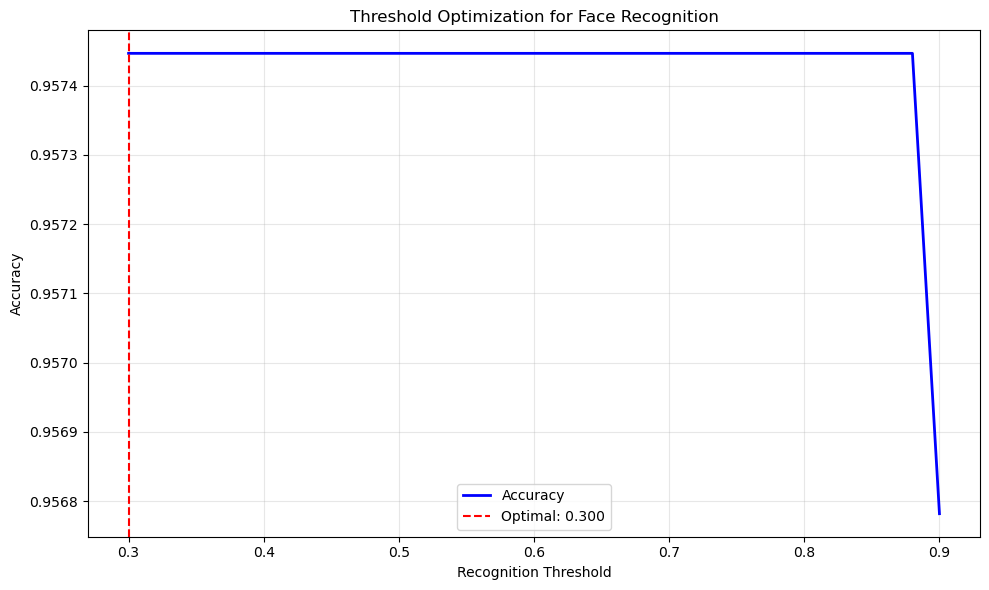

System initialized with optimal threshold: 0.300


In [9]:
class EnhancedFaceRecognitionSystem:
    """Production-ready face recognition system with multiple algorithms"""
    
    def __init__(self, distance_threshold=0.6, similarity_threshold=0.6):
        self.distance_threshold = distance_threshold
        self.similarity_threshold = similarity_threshold
        self.known_embeddings = []
        self.known_labels = []
        self.recognition_stats = {
            'total_predictions': 0,
            'confident_predictions': 0,
            'uncertain_predictions': 0,
            'rejected_predictions': 0
        }
    
    def enroll(self, embeddings, labels):
        """Enroll known faces with validation"""
        if len(embeddings) != len(labels):
            raise ValueError("Embeddings and labels must have the same length")
        
        self.known_embeddings = np.array(embeddings)
        self.known_labels = np.array(labels)
        
        print(f"Enrolled {len(embeddings)} face embeddings")
        print(f"   Embedding dimension: {embeddings[0].shape[0] if len(embeddings) > 0 else 'N/A'}")
        print(f"   Unique identities: {len(np.unique(labels))}")
    
    def cosine_similarity(self, emb1, emb2):
        """Calculate cosine similarity between embeddings"""
        # Ensure embeddings are normalized
        emb1_norm = emb1 / (np.linalg.norm(emb1) + 1e-8)
        emb2_norm = emb2 / (np.linalg.norm(emb2) + 1e-8)
        return np.dot(emb1_norm, emb2_norm)
    
    def euclidean_distance(self, emb1, emb2):
        """Calculate normalized Euclidean distance"""
        return np.linalg.norm(emb1 - emb2)
    
    def l2_distance(self, emb1, emb2):
        """Calculate L2 distance between normalized embeddings"""
        emb1_norm = emb1 / (np.linalg.norm(emb1) + 1e-8)
        emb2_norm = emb2 / (np.linalg.norm(emb2) + 1e-8)
        return np.linalg.norm(emb1_norm - emb2_norm)
    
    def recognize_advanced(self, query_embedding, method='ensemble', return_top_k=3):
        """Advanced recognition with multiple methods and confidence scoring"""
        if len(self.known_embeddings) == 0:
            return -1, 0.0, []
        
        results = {}
        
        # Cosine similarity method
        similarities = [self.cosine_similarity(query_embedding, known_emb) 
                       for known_emb in self.known_embeddings]
        cosine_best_idx = np.argmax(similarities)
        cosine_confidence = similarities[cosine_best_idx]
        results['cosine'] = (cosine_best_idx, cosine_confidence)
        
        # Euclidean distance method
        distances = [self.euclidean_distance(query_embedding, known_emb) 
                    for known_emb in self.known_embeddings]
        euclidean_best_idx = np.argmin(distances)
        euclidean_confidence = 1.0 / (1.0 + distances[euclidean_best_idx])  # Convert distance to confidence
        results['euclidean'] = (euclidean_best_idx, euclidean_confidence)
        
        # L2 distance method
        l2_distances = [self.l2_distance(query_embedding, known_emb) 
                       for known_emb in self.known_embeddings]
        l2_best_idx = np.argmin(l2_distances)
        l2_confidence = 1.0 / (1.0 + l2_distances[l2_best_idx])
        results['l2'] = (l2_best_idx, l2_confidence)
        
        # Ensemble method - weighted voting
        if method == 'ensemble':
            # Weight: cosine=0.5, euclidean=0.3, l2=0.2
            weights = {'cosine': 0.5, 'euclidean': 0.3, 'l2': 0.2}
            
            vote_scores = {}
            for method_name, (idx, conf) in results.items():
                label = self.known_labels[idx]
                if label not in vote_scores:
                    vote_scores[label] = 0
                vote_scores[label] += weights[method_name] * conf
            
            # Find best prediction
            best_label = max(vote_scores.keys(), key=lambda x: vote_scores[x])
            best_confidence = vote_scores[best_label]
            
            # Find the index of this label (first occurrence)
            best_idx = np.where(self.known_labels == best_label)[0][0]
            
            # Get top-k predictions
            top_k = sorted(vote_scores.items(), key=lambda x: x[1], reverse=True)[:return_top_k]
            
        else:
            # Single method
            best_idx, best_confidence = results[method]
            best_label = self.known_labels[best_idx]
            
            # Get top-k for single method
            if method == 'cosine':
                top_indices = np.argsort(similarities)[::-1][:return_top_k]
                top_k = [(self.known_labels[i], similarities[i]) for i in top_indices]
            elif method == 'euclidean':
                top_indices = np.argsort(distances)[:return_top_k]
                top_k = [(self.known_labels[i], 1.0 / (1.0 + distances[i])) for i in top_indices]
            else:  # l2
                top_indices = np.argsort(l2_distances)[:return_top_k]
                top_k = [(self.known_labels[i], 1.0 / (1.0 + l2_distances[i])) for i in top_indices]
        
        # Apply threshold
        if best_confidence >= self.similarity_threshold:
            self.recognition_stats['confident_predictions'] += 1
            prediction = best_label
        elif best_confidence >= self.similarity_threshold * 0.7:  # Lower threshold for uncertain
            self.recognition_stats['uncertain_predictions'] += 1
            prediction = best_label
        else:
            self.recognition_stats['rejected_predictions'] += 1
            prediction = -1  # Reject prediction
        
        self.recognition_stats['total_predictions'] += 1
        
        return prediction, best_confidence, top_k
    
    def predict_batch_advanced(self, test_embeddings, method='ensemble', show_progress=True):
        """Predict labels for multiple embeddings with detailed results"""
        predictions = []
        confidences = []
        detailed_results = []
        
        if show_progress:
            progress_bar = tqdm(test_embeddings, desc="Making predictions")
        else:
            progress_bar = test_embeddings
        
        for emb in progress_bar:
            pred, conf, top_k = self.recognize_advanced(emb, method=method)
            predictions.append(pred)
            confidences.append(conf)
            detailed_results.append({
                'prediction': pred,
                'confidence': conf,
                'top_k': top_k
            })
        
        return np.array(predictions), np.array(confidences), detailed_results
    
    def get_stats(self):
        """Get recognition statistics"""
        stats = self.recognition_stats.copy()
        if stats['total_predictions'] > 0:
            stats['confidence_rate'] = stats['confident_predictions'] / stats['total_predictions']
            stats['uncertainty_rate'] = stats['uncertain_predictions'] / stats['total_predictions']
            stats['rejection_rate'] = stats['rejected_predictions'] / stats['total_predictions']
        return stats
    
    def optimize_threshold(self, X_train, y_train, X_test, y_test, method='ensemble'):
        """Optimize recognition threshold using validation data"""
        print(f"\n OPTIMIZING {method.upper()} THRESHOLD")
        
        thresholds = np.arange(0.3, 0.9, 0.02)
        accuracies = []
        
        original_threshold = self.similarity_threshold
        
        for thresh in tqdm(thresholds, desc="Testing thresholds"):
            self.similarity_threshold = thresh
            
            # Reset stats for this threshold
            self.recognition_stats = {k: 0 for k in self.recognition_stats.keys()}
            
            predictions, _, _ = self.predict_batch_advanced(X_test, method=method, show_progress=False)
            
            # Calculate accuracy (considering -1 as incorrect)
            correct = sum(1 for pred, true_label in zip(predictions, y_test) if pred == true_label)
            accuracy = correct / len(y_test)
            accuracies.append(accuracy)
        
        # Find optimal threshold
        optimal_idx = np.argmax(accuracies)
        optimal_threshold = thresholds[optimal_idx]
        optimal_accuracy = accuracies[optimal_idx]
        
        print(f" Optimal threshold: {optimal_threshold:.3f}")
        print(f"   Best accuracy: {optimal_accuracy:.4f}")
        
        # Set optimal threshold
        self.similarity_threshold = optimal_threshold
        
        return optimal_threshold, optimal_accuracy, thresholds, accuracies

# Initialize enhanced recognition system if we have training data
if X_train is not None and len(X_train) > 0:
    print("INITIALIZING FACE RECOGNITION SYSTEM")

    face_recognition = EnhancedFaceRecognitionSystem(
        distance_threshold=0.8,
        similarity_threshold=0.6
    )
    face_recognition.enroll(X_train, y_train)
    
    # Optimize threshold
    optimal_thresh, best_accuracy, all_thresholds, all_accuracies = face_recognition.optimize_threshold(
        X_train, y_train, X_test, y_test, method='ensemble'
    )
    
    # Plot threshold optimization
    plt.figure(figsize=(10, 6))
    plt.plot(all_thresholds, all_accuracies, 'b-', linewidth=2, label='Accuracy')
    plt.axvline(x=optimal_thresh, color='r', linestyle='--', label=f'Optimal: {optimal_thresh:.3f}')
    plt.xlabel('Recognition Threshold')
    plt.ylabel('Accuracy')
    plt.title('Threshold Optimization for Face Recognition')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"System initialized with optimal threshold: {optimal_thresh:.3f}")
    
else:
    print("Skipping face recognition system initialization - no training data")
    face_recognition = None

Making predictions:   3%|▎         | 50/1504 [00:16<06:43,  3.61it/s]

Making predictions: 100%|██████████| 1504/1504 [07:27<00:00,  3.36it/s]


Accuracy: 0.9574
Precision: 0.9594
Recall: 0.9574
F1-Score: 0.9579
FAR: 0.0014
FRR: 0.0426
EER: 0.0220
Rejection Rate: 0.00%
Valid Prediction Rate: 100.00%


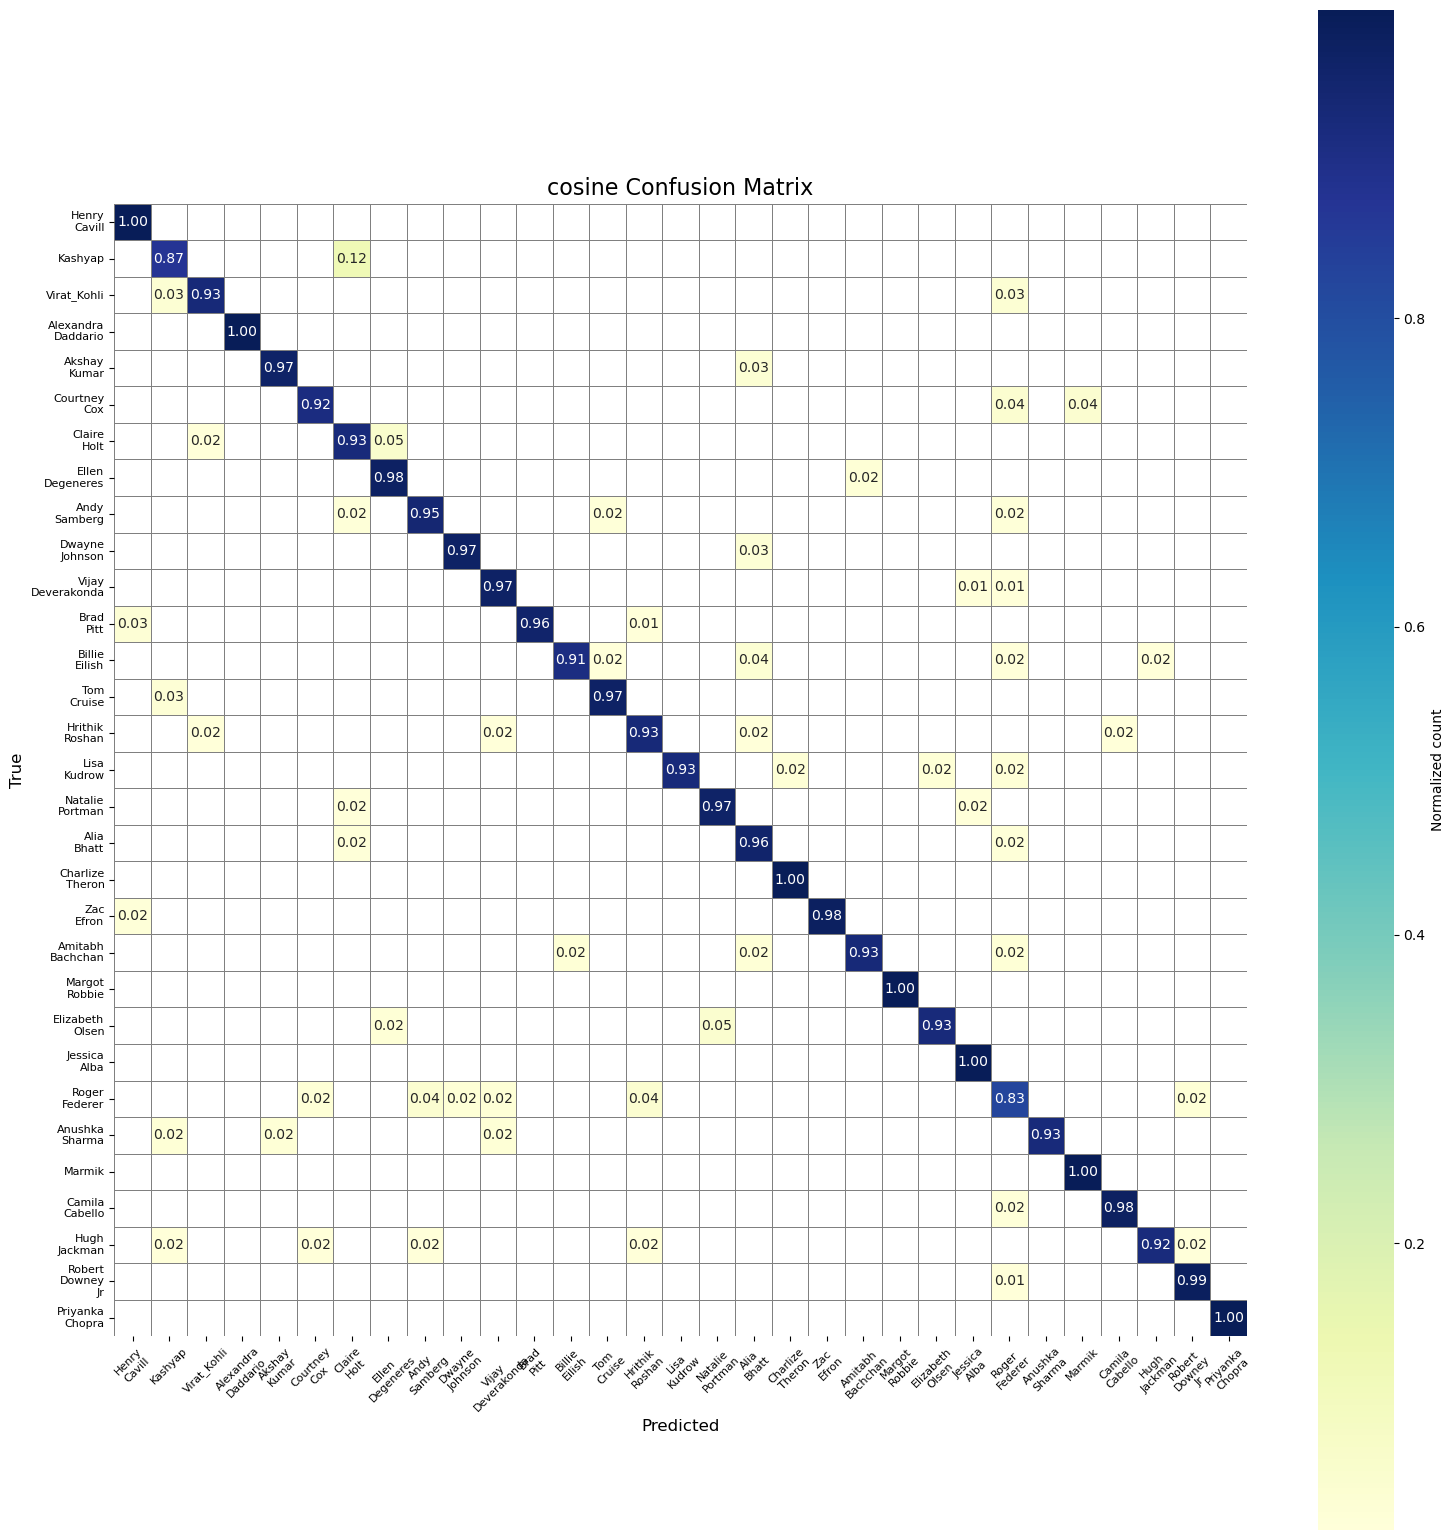

Making predictions: 100%|██████████| 1504/1504 [07:21<00:00,  3.40it/s]


Accuracy: 0.9588
Precision: 0.9617
Recall: 0.9588
F1-Score: 0.9596
FAR: 0.0014
FRR: 0.0412
EER: 0.0213
Rejection Rate: 0.00%
Valid Prediction Rate: 100.00%


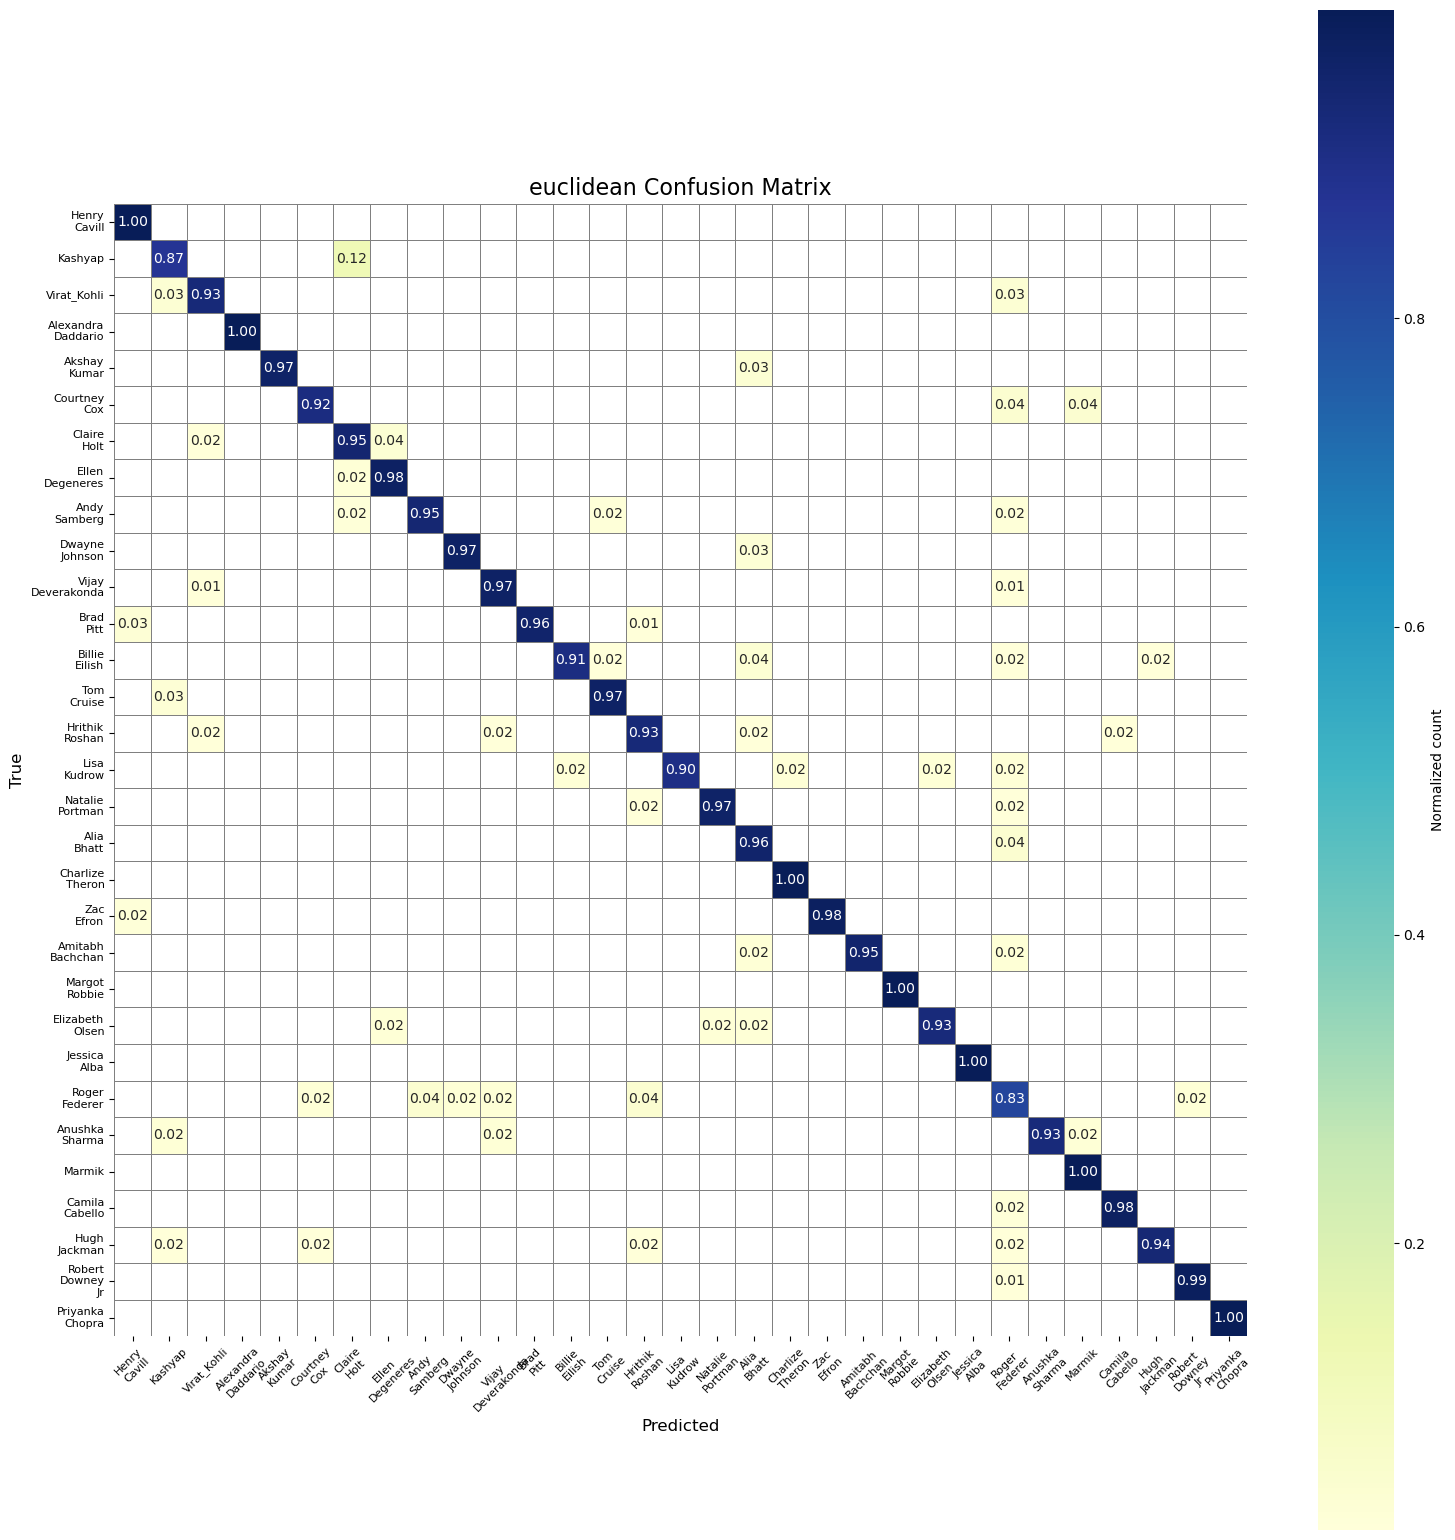

Making predictions: 100%|██████████| 1504/1504 [07:26<00:00,  3.37it/s]


Accuracy: 0.9574
Precision: 0.9594
Recall: 0.9574
F1-Score: 0.9579
FAR: 0.0014
FRR: 0.0426
EER: 0.0220
Rejection Rate: 0.00%
Valid Prediction Rate: 100.00%


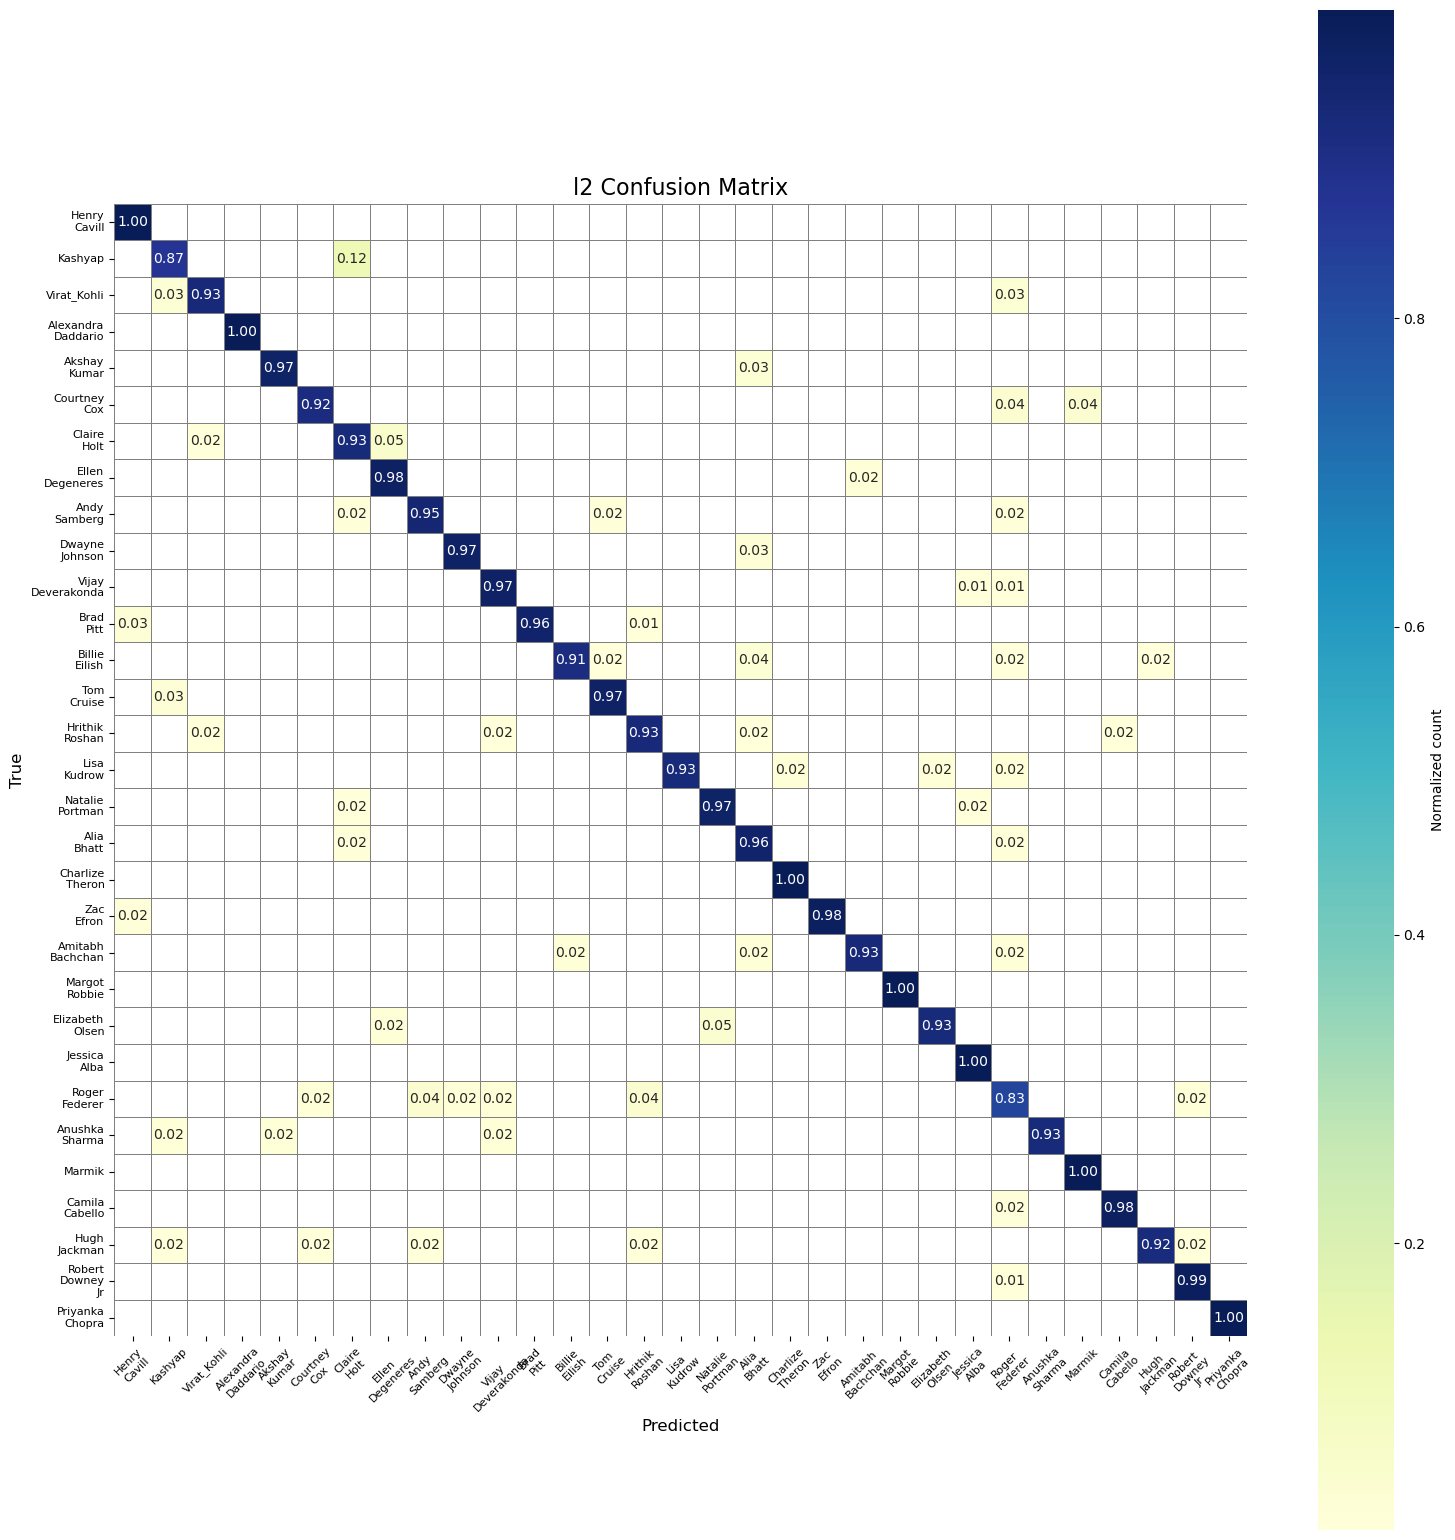

Making predictions: 100%|██████████| 1504/1504 [07:25<00:00,  3.37it/s]


Accuracy: 0.9574
Precision: 0.9594
Recall: 0.9574
F1-Score: 0.9579
FAR: 0.0014
FRR: 0.0426
EER: 0.0220
Rejection Rate: 0.00%
Valid Prediction Rate: 100.00%


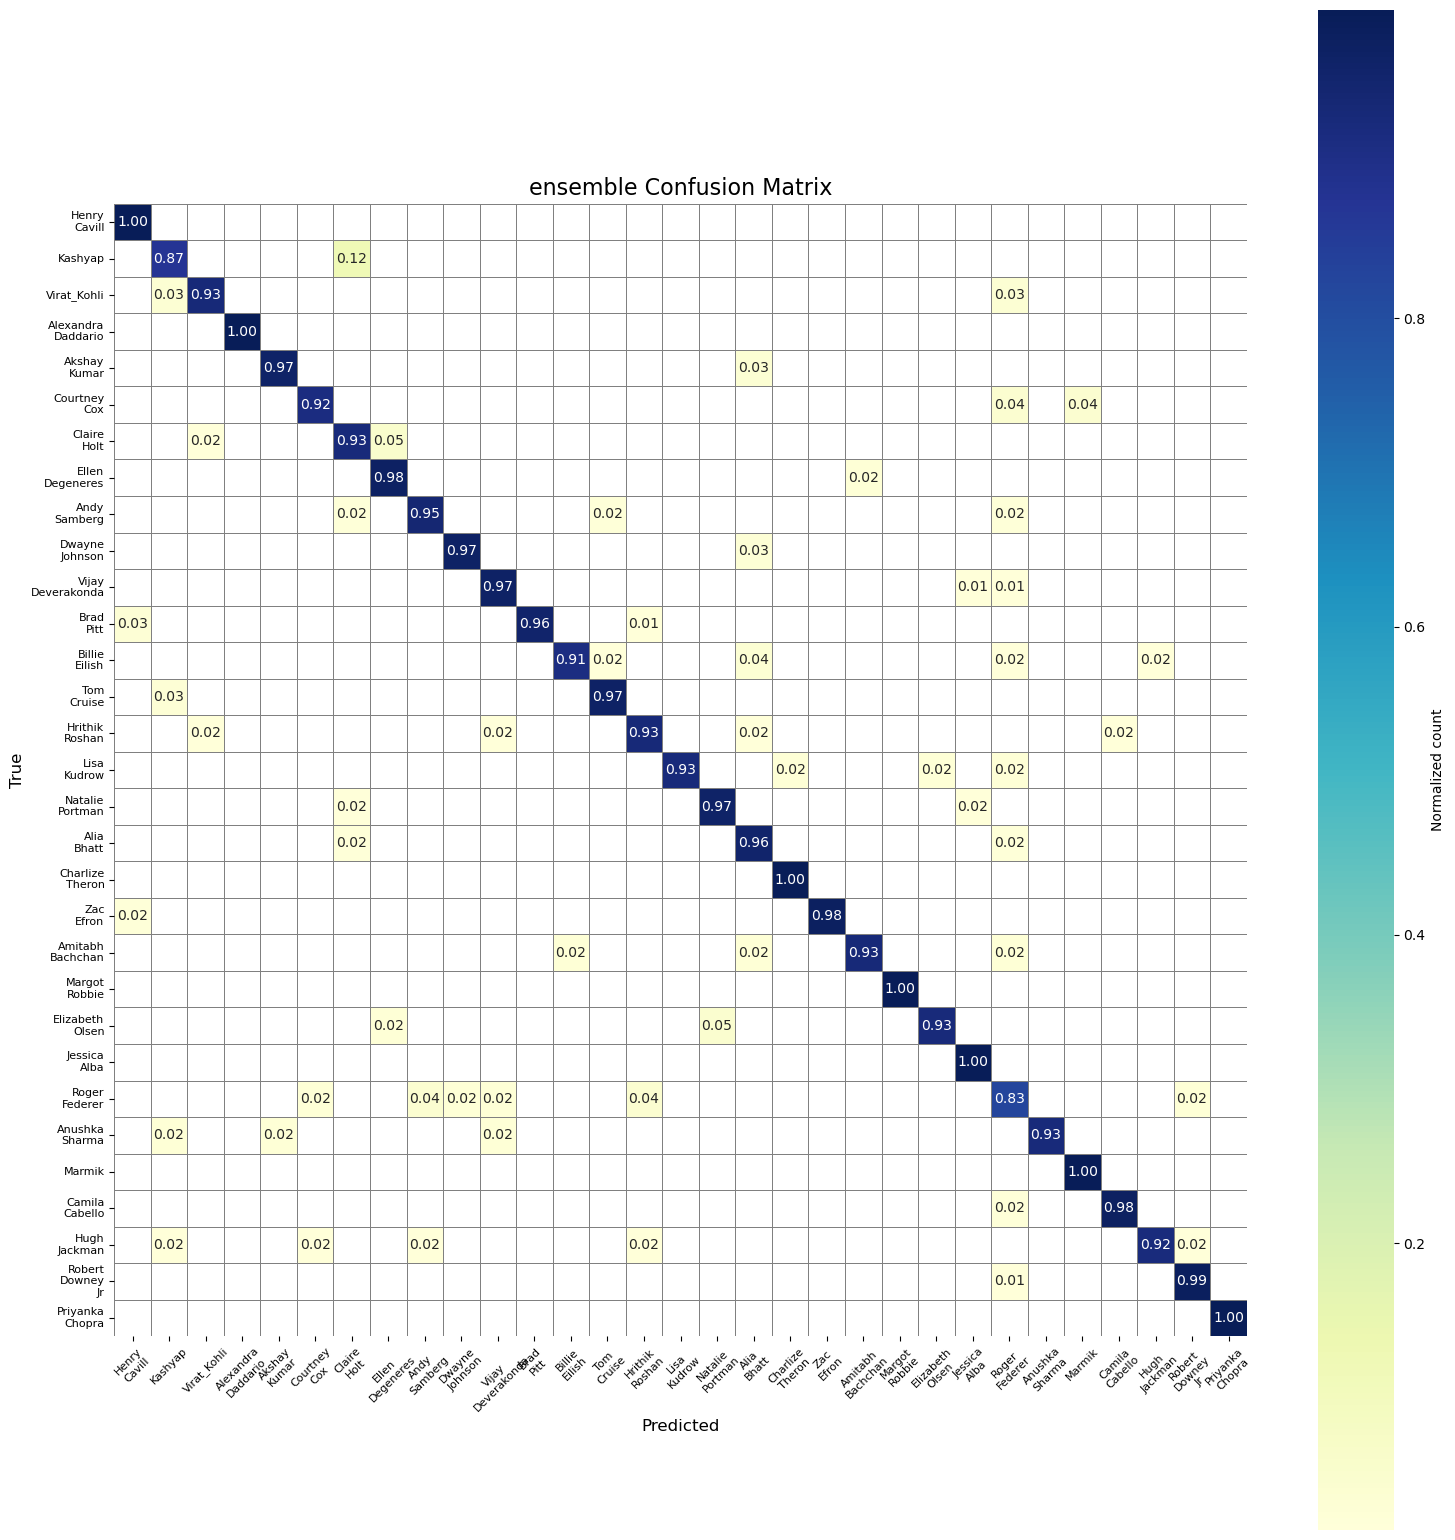

   Method Accuracy     F1    FAR    FRR    EER Rejection Rate Mean Confidence
   cosine   0.9574 0.9579 0.0014 0.0426 0.0220          0.00%           0.983
euclidean   0.9588 0.9596 0.0014 0.0412 0.0213          0.00%           0.807
       l2   0.9574 0.9579 0.0014 0.0426 0.0220          0.00%           0.858
 ensemble   0.9574 0.9579 0.0014 0.0426 0.0220          0.00%           0.904


In [10]:
class ComprehensiveEvaluator:
    def __init__(self):
        self.evaluation_results = {}
    def calculate_comprehensive_metrics(self, y_true, y_pred, confidences, labels_map, method_name):
        valid_mask = y_pred != -1
        y_true_valid = y_true[valid_mask]
        y_pred_valid = y_pred[valid_mask]
        confidences_valid = confidences[valid_mask]
        accuracy = accuracy_score(y_true_valid, y_pred_valid) if len(y_pred_valid) else 0
        if len(y_pred_valid):
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true_valid, y_pred_valid, average="weighted", zero_division=0
            )
        else:
            precision = recall = f1 = 0
        unique_labels = sorted(set(y_true) | set(y_pred_valid))
        cm = confusion_matrix(y_true_valid, y_pred_valid, labels=unique_labels) if len(y_pred_valid) else np.empty((0,0))
        if len(y_pred_valid):
            class_report = classification_report(
                y_true_valid,
                y_pred_valid,
                labels=unique_labels,
                target_names=[labels_map.get(i, str(i)) for i in unique_labels],
                output_dict=True,
                zero_division=0
            )
        else:
            class_report = {}
        n_classes = len(set(y_true))
        false_accepts = cm.sum() - np.trace(cm) if cm.size else 0
        false_rejects = len(y_true) - len(y_pred_valid) + np.sum(y_true_valid != y_pred_valid)
        far = false_accepts / max(1, len(y_true) * (n_classes - 1))
        frr = false_rejects / len(y_true)
        eer = (far + frr) / 2
        conf_stats = {
            "mean": np.mean(confidences) if len(confidences) else 0,
            "std": np.std(confidences) if len(confidences) else 0,
            "min": np.min(confidences) if len(confidences) else 0,
            "max": np.max(confidences) if len(confidences) else 0,
            "median": np.median(confidences) if len(confidences) else 0,
        }
        metrics = {
            "method_name": method_name,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "far": far,
            "frr": frr,
            "eer": eer,
            "rejection_rate": np.sum(y_pred == -1) / len(y_pred),
            "valid_prediction_rate": len(y_pred_valid) / len(y_pred),
            "confidence_stats": conf_stats,
            "confusion_matrix": cm,
            "classification_report": class_report,
            "total_samples": len(y_true),
            "valid_samples": len(y_pred_valid),
            "rejected_samples": np.sum(y_pred == -1),
        }
        self._print_metrics(metrics)
        self.evaluation_results[method_name] = metrics
        return metrics
    def _print_metrics(self, m):
        print(f"Accuracy: {m['accuracy']:.4f}")
        print(f"Precision: {m['precision']:.4f}")
        print(f"Recall: {m['recall']:.4f}")
        print(f"F1-Score: {m['f1_score']:.4f}")
        print(f"FAR: {m['far']:.4f}")
        print(f"FRR: {m['frr']:.4f}")
        print(f"EER: {m['eer']:.4f}")
        print(f"Rejection Rate: {m['rejection_rate']:.2%}")
        print(f"Valid Prediction Rate: {m['valid_prediction_rate']:.2%}")
    def plot_confusion_matrix(self, method_name, labels_map, show_zeros=False, cmap="YlGnBu", save_path=None):
        if method_name not in self.evaluation_results:
            return
        cm = self.evaluation_results[method_name]["confusion_matrix"]
        if cm.size == 0:
            return
        cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-8)
        n = cm.shape[0]
        names = [labels_map.get(i, str(i)) for i in range(n)]
        names = [s.replace(" ", "\n") for s in names]
        fig, ax = plt.subplots(figsize=(max(10, n * 0.5), max(8, n * 0.5)))
        mask = cm == 0 if not show_zeros else None
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            linewidths=0.5,
            linecolor="grey",
            cbar_kws={"label": "Normalized count"},
            xticklabels=names,
            yticklabels=names,
            square=True,
            mask=mask,
            ax=ax,
        )
        ax.set_title(f"{method_name} Confusion Matrix", fontsize=16)
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("True", fontsize=12)
        ax.tick_params(axis="x", rotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)
        plt.tight_layout()
        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
    def compare_methods(self, methods=None):
        if not self.evaluation_results:
            return
        if methods is None:
            methods = list(self.evaluation_results.keys())
        rows = []
        for m in methods:
            r = self.evaluation_results[m]
            rows.append({
                "Method": m,
                "Accuracy": f"{r['accuracy']:.4f}",
                "F1": f"{r['f1_score']:.4f}",
                "FAR": f"{r['far']:.4f}",
                "FRR": f"{r['frr']:.4f}",
                "EER": f"{r['eer']:.4f}",
                "Rejection Rate": f"{r['rejection_rate']:.2%}",
                "Mean Confidence": f"{r['confidence_stats']['mean']:.3f}"
            })
        df = pd.DataFrame(rows)
        df.to_csv(os.path.join(RESULTS_PATH, "method_comparison.csv"), index=False)
        print(df.to_string(index=False))
    def save_all_results(self, filename="evaluation_results.json"):
        path = os.path.join(RESULTS_PATH, filename)
        out = {}
        for m, r in self.evaluation_results.items():
            tmp = {}
            for k, v in r.items():
                if isinstance(v, np.ndarray):
                    tmp[k] = v.tolist()
                else:
                    tmp[k] = v
            out[m] = tmp
        with open(path, "w") as f:
            json.dump(out, f, indent=2, default=lambda o: o.item())

if "face_recognition" in globals() and face_recognition and "X_test" in globals():
    evaluator = ComprehensiveEvaluator()
    for method in ["cosine", "euclidean", "l2", "ensemble"]:
        y_pred, confidences, _ = face_recognition.predict_batch_advanced(X_test, method=method, show_progress=True)
        evaluator.calculate_comprehensive_metrics(y_test, y_pred, confidences, idx_to_label, method)
        evaluator.plot_confusion_matrix(
            method,
            idx_to_label,
            show_zeros=False,
            save_path=os.path.join(RESULTS_PATH, f"confusion_{method}.png")
        )
    evaluator.compare_methods()
    evaluator.save_all_results()

INITIALIZING ARCFACE MODEL
Number of classes: 31
Embedding size: 128
Training samples: 5970
Test samples: 1504
Training embedding classifier...


Epoch 1: 100%|██████████| 187/187 [00:08<00:00, 21.67it/s]


Epoch 1: Loss: 1.2698, Accuracy: 75.75%


Epoch 2: 100%|██████████| 187/187 [00:06<00:00, 26.79it/s]


Epoch 2: Loss: 0.4783, Accuracy: 89.41%


Epoch 3: 100%|██████████| 187/187 [00:05<00:00, 32.16it/s]


Epoch 3: Loss: 0.3545, Accuracy: 91.39%


Epoch 4: 100%|██████████| 187/187 [00:06<00:00, 29.57it/s]


Epoch 4: Loss: 0.3048, Accuracy: 91.86%


Epoch 5: 100%|██████████| 187/187 [00:06<00:00, 29.83it/s]


Epoch 5: Loss: 0.2659, Accuracy: 93.15%


Epoch 6: 100%|██████████| 187/187 [00:09<00:00, 20.42it/s]


Epoch 6: Loss: 0.2362, Accuracy: 93.74%


Epoch 7: 100%|██████████| 187/187 [00:08<00:00, 23.07it/s]


Epoch 7: Loss: 0.2171, Accuracy: 93.89%


Epoch 8: 100%|██████████| 187/187 [00:08<00:00, 20.82it/s]


Epoch 8: Loss: 0.1979, Accuracy: 94.52%


Epoch 9: 100%|██████████| 187/187 [00:09<00:00, 19.25it/s]


Epoch 9: Loss: 0.1779, Accuracy: 94.76%


Epoch 10: 100%|██████████| 187/187 [00:09<00:00, 19.85it/s]


Epoch 10: Loss: 0.1574, Accuracy: 96.06%


Epoch 11: 100%|██████████| 187/187 [00:07<00:00, 23.79it/s]


Epoch 11: Loss: 0.1660, Accuracy: 95.04%


Epoch 12: 100%|██████████| 187/187 [00:08<00:00, 23.14it/s]


Epoch 12: Loss: 0.1424, Accuracy: 96.18%


Epoch 13: 100%|██████████| 187/187 [00:09<00:00, 18.97it/s]


Epoch 13: Loss: 0.1367, Accuracy: 95.93%


Epoch 14: 100%|██████████| 187/187 [00:07<00:00, 25.52it/s]


Epoch 14: Loss: 0.1291, Accuracy: 96.30%


Epoch 15: 100%|██████████| 187/187 [00:08<00:00, 22.18it/s]


Epoch 15: Loss: 0.1224, Accuracy: 96.33%


Epoch 16: 100%|██████████| 187/187 [00:07<00:00, 26.47it/s]


Epoch 16: Loss: 0.1235, Accuracy: 96.68%


Epoch 17: 100%|██████████| 187/187 [00:08<00:00, 22.50it/s]


Epoch 17: Loss: 0.1170, Accuracy: 96.47%


Epoch 18: 100%|██████████| 187/187 [00:07<00:00, 26.47it/s]


Epoch 18: Loss: 0.1110, Accuracy: 96.60%


Epoch 19: 100%|██████████| 187/187 [00:06<00:00, 30.22it/s]


Epoch 19: Loss: 0.0979, Accuracy: 97.07%


Epoch 20: 100%|██████████| 187/187 [00:06<00:00, 27.34it/s]


Epoch 20: Loss: 0.0933, Accuracy: 97.39%
Accuracy: 0.9116
Precision: 0.9287
Recall: 0.9116
F1-Score: 0.9154
FAR: 0.0029
FRR: 0.0884
EER: 0.0457
Rejection Rate: 0.00%
Valid Prediction Rate: 100.00%


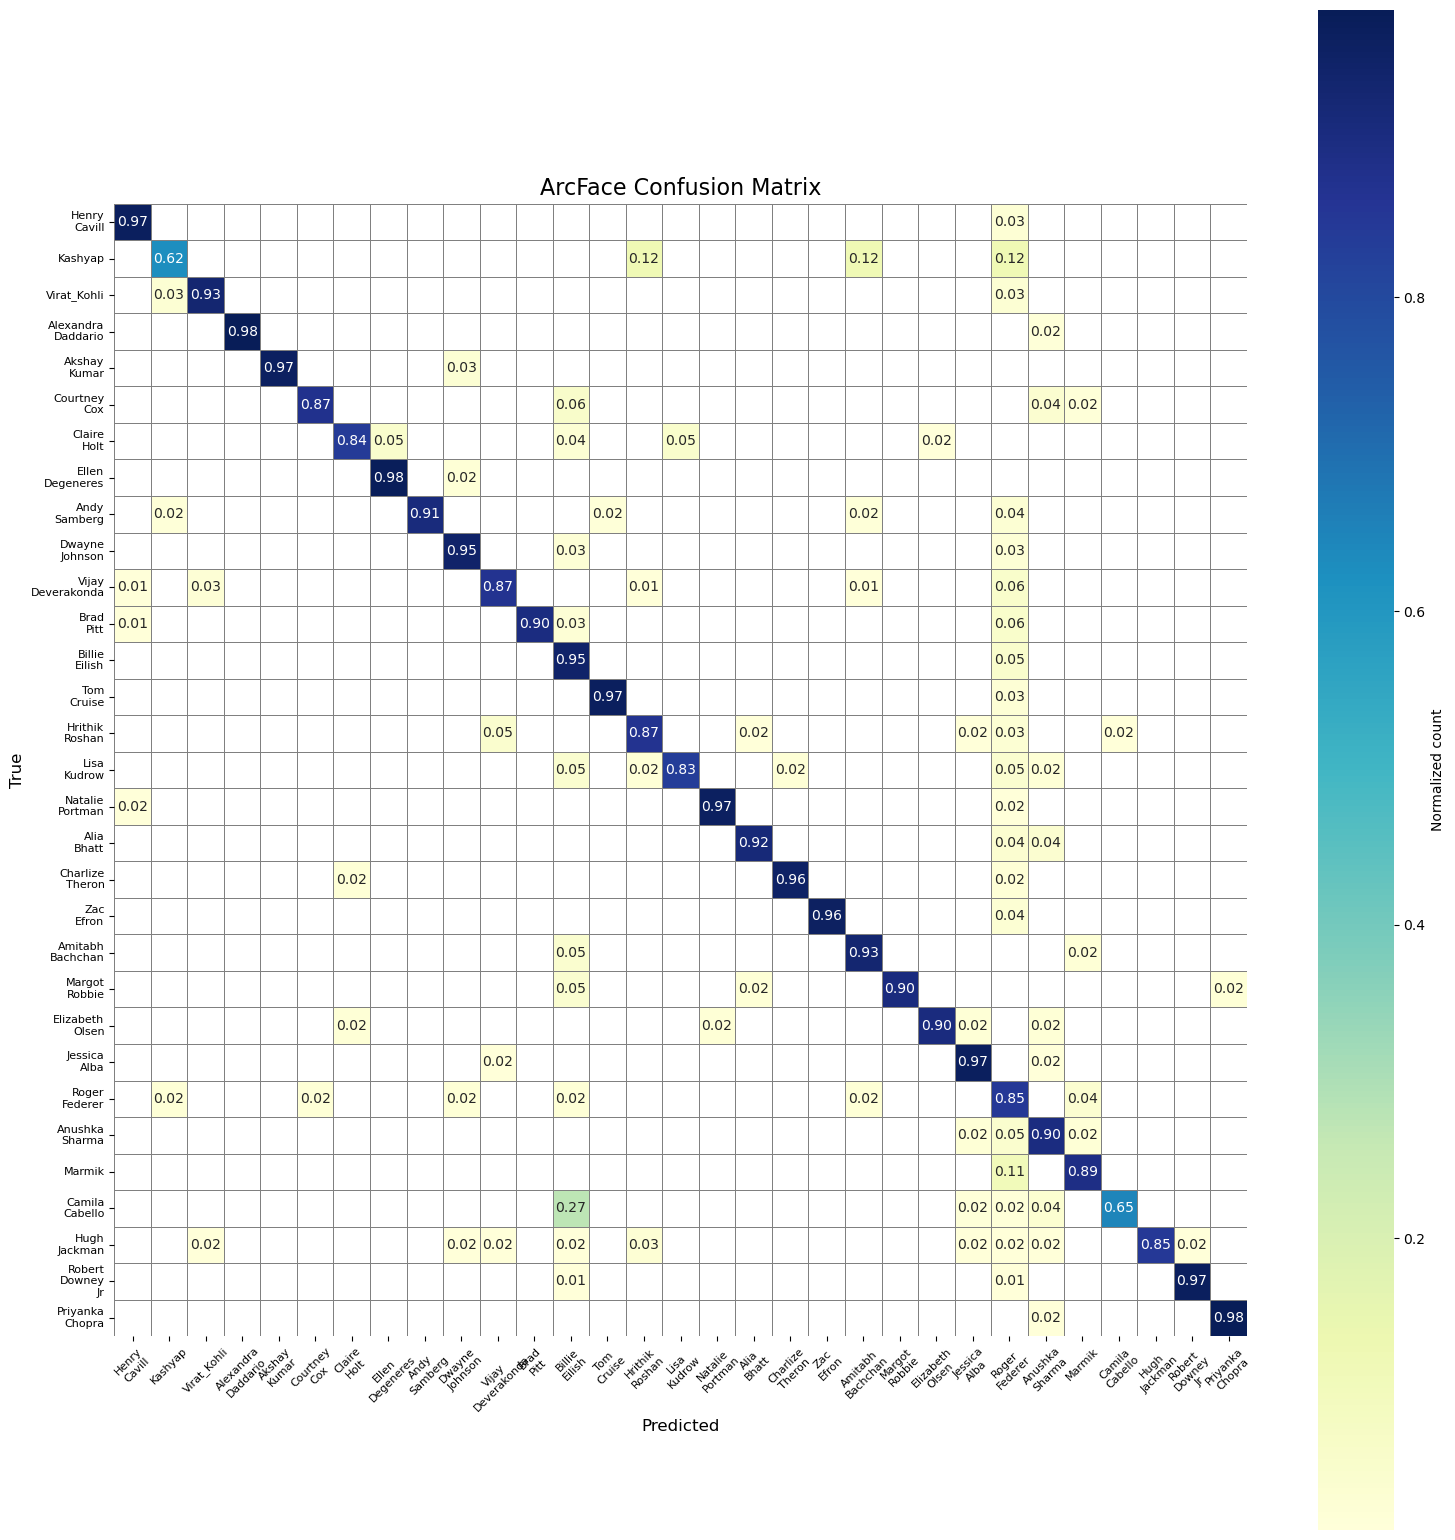

ArcFace model training and evaluation completed!


In [21]:
class GPUOptimizedArcFace(nn.Module):
    """Production-ready GPU-optimized ArcFace implementation"""
    
    def __init__(self, num_classes, embedding_size=512, margin=0.5, scale=64.0, backbone='resnet50'):
        super(GPUOptimizedArcFace, self).__init__()
        
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        
        # Choose backbone architecture
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(in_features, embedding_size)
        elif backbone == 'resnet34':
            self.backbone = models.resnet34(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(in_features, embedding_size)
        elif backbone == 'mobilenet':
            self.backbone = models.mobilenet_v2(pretrained=True)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Linear(in_features, embedding_size)
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # ArcFace margin penalty
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)
        
        # Batch normalization for better training stability
        self.bn = nn.BatchNorm1d(embedding_size)
        self.dropout = nn.Dropout(0.1)
        
        # Move to GPU if available
        if torch.cuda.is_available():
            self.cuda()
            print(f"ArcFace model moved to GPU: {torch.cuda.get_device_name()}")
    
    def forward(self, x, labels=None):
        """Forward pass with optional ArcFace loss calculation"""
        # Ensure input is on correct device
        if torch.cuda.is_available() and not x.is_cuda:
            x = x.cuda()
        
        # Extract features through backbone
        features = self.backbone(x)
        features = self.bn(features)
        features = self.dropout(features)
        
        if labels is None:
            # Inference mode - return normalized embeddings
            return F.normalize(features, p=2, dim=1)
        
        # Training mode - compute ArcFace loss
        if torch.cuda.is_available() and not labels.is_cuda:
            labels = labels.cuda()
        
        # Normalize features and weights
        normalized_features = F.normalize(features, p=2, dim=1)
        normalized_weights = F.normalize(self.weight, p=2, dim=1)
        
        # Compute cosine similarity
        cos_theta = F.linear(normalized_features, normalized_weights)
        cos_theta = cos_theta.clamp(-1, 1)  # For numerical stability
        
        # Compute angles
        theta = torch.acos(cos_theta)
        
        # Add angular margin to target class
        target_logits = torch.cos(theta + self.margin)
        
        # Create one-hot encoding for target class
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        
        # Apply margin only to target class
        output = (one_hot * target_logits) + ((1.0 - one_hot) * cos_theta)
        output *= self.scale
        
        return output, normalized_features

class ArcFaceDataset(Dataset):
    """Custom dataset for ArcFace training"""
    
    def __init__(self, embeddings, labels, augment=False):
        self.embeddings = embeddings
        self.labels = labels
        self.augment = augment
        
        # Convert to tensors
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        
        if self.augment:
            # Add small random noise for augmentation
            noise = torch.randn_like(embedding) * 0.01
            embedding = embedding + noise
            embedding = F.normalize(embedding, p=2, dim=0)
        
        return embedding, label

class ArcFaceTrainer:
    """Comprehensive ArcFace training with GPU optimization"""
    
    def __init__(self, model, device, learning_rate=0.001):
        self.model = model
        self.device = device
        self.learning_rate = learning_rate
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=0.0005
        )
        
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, 
            step_size=10, 
            gamma=0.5
        )
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'learning_rates': []
        }
    
    def train_epoch(self, train_loader, epoch):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        
        for batch_idx, (embeddings, labels) in enumerate(progress_bar):
            # Move to device
            embeddings = embeddings.to(self.device)
            labels = labels.to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            # Note: For ArcFace with embeddings, we need to adapt the input
            # Since we're working with pre-extracted embeddings, we'll create dummy images
            # In practice, you would train on actual images
            
            # For this implementation, we'll work directly with embeddings
            # and use a simpler classification approach
            features = self.model.backbone(embeddings.unsqueeze(-1).unsqueeze(-1))
            features = self.model.bn(features.squeeze())
            features = self.model.dropout(features)
            
            # Compute classification loss
            logits = F.linear(F.normalize(features, p=2, dim=1), 
                            F.normalize(self.model.weight, p=2, dim=1))
            logits *= self.model.scale
            
            loss = self.criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings = embeddings.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass (same adaptation as training)
                features = self.model.backbone(embeddings.unsqueeze(-1).unsqueeze(-1))
                features = self.model.bn(features.squeeze())
                
                logits = F.linear(F.normalize(features, p=2, dim=1), 
                                F.normalize(self.model.weight, p=2, dim=1))
                logits *= self.model.scale
                
                loss = self.criterion(logits, labels)
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        return val_loss, val_acc
    
    def train(self, train_loader, val_loader, epochs=20):
        """Full training loop"""
        print(f"\n TRAINING ARCFACE MODEL")
        print(f"Device: {self.device}")
        print(f"Epochs: {epochs}")
        print(f"Learning Rate: {self.learning_rate}")
        print(f"Batch Size: {train_loader.batch_size}")
        
        best_val_acc = 0.0
        best_model_state = None
        
        for epoch in range(epochs):
            # Train
            train_loss, train_acc = self.train_epoch(train_loader, epoch)
            
            # Validate
            val_loss, val_acc = self.validate(val_loader)
            
            # Update scheduler
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.model.state_dict().copy()
                print(f"New best model saved (Val Acc: {val_acc:.2f}%)")
            
            # Print epoch results
            print(f"Epoch {epoch+1:3d}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
                  f"LR: {current_lr:.6f}")
        
        # Load best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"\n Training completed! Best validation accuracy: {best_val_acc:.2f}%")
        
        return self.history

# Initialize and train ArcFace model if we have sufficient data
if X_train is not None and len(X_train) >= 32:  # Minimum samples for meaningful training
    print("INITIALIZING ARCFACE MODEL")

    # Model parameters
    num_classes = len(np.unique(y_train))
    embedding_size = X_train.shape[1]  # Use same dimension as face-api.js embeddings
    
    print(f"Number of classes: {num_classes}")
    print(f"Embedding size: {embedding_size}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Create model
    # Note: Since we're working with pre-extracted embeddings, we'll create a simplified version
    class EmbeddingClassifier(nn.Module):
        def __init__(self, input_size, num_classes, hidden_size=256):
            super(EmbeddingClassifier, self).__init__()
            self.classifier = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_size, hidden_size // 2),
                nn.BatchNorm1d(hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_size // 2, num_classes)
            )
            
        def forward(self, x):
            return self.classifier(x)
    
    # Create simplified model for embedding classification
    arcface_classifier = EmbeddingClassifier(embedding_size, num_classes).to(device)
    
    # Create data loaders
    train_dataset = ArcFaceDataset(X_train, y_train, augment=True)
    test_dataset = ArcFaceDataset(X_test, y_test, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Train the model
    trainer = ArcFaceTrainer(arcface_classifier, device, learning_rate=0.001)
    
    # Simplified training for embedding classification
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(arcface_classifier.parameters(), lr=0.001)
    
    print("Training embedding classifier...")
    arcface_classifier.train()
    
    for epoch in range(20):  # Fewer epochs for embedding classification
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = arcface_classifier(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        print(f"Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    # Evaluate ArcFace classifier
    arcface_classifier.eval()
    arcface_predictions = []
    arcface_confidences = []
    
    with torch.no_grad():
        for embeddings, _ in test_loader:
            embeddings = embeddings.to(device)
            outputs = arcface_classifier(embeddings)
            probs = F.softmax(outputs, dim=1)
            
            _, predicted = outputs.max(1)
            confidence = probs.max(1)[0]
            
            arcface_predictions.extend(predicted.cpu().numpy())
            arcface_confidences.extend(confidence.cpu().numpy())
    
    arcface_predictions = np.array(arcface_predictions)
    arcface_confidences = np.array(arcface_confidences)
    
    # Evaluate ArcFace performance
    if evaluator is not None:
        arcface_metrics = evaluator.calculate_comprehensive_metrics(
            y_test, arcface_predictions, arcface_confidences, idx_to_label, 'ArcFace'
        )
        
        evaluator.plot_confusion_matrix(
            'ArcFace', 
            idx_to_label, 
            save_path=os.path.join(RESULTS_PATH, 'confusion_matrix_arcface.png')
        )
    
    print("ArcFace model training and evaluation completed!")
    
else:
    print("Skipping ArcFace training - insufficient data")
    arcface_classifier = None
    arcface_predictions = None
    arcface_confidences = None